In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import kurtosis
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

In [2]:
df = pd.read_csv(
    "/Users/admin/Desktop/TSA Project/stock_data.csv",
    header=0,
    index_col=0, 
    parse_dates=True
)
print(df.head())
print(df.columns)

              S&P 500       Apple   EUR/USD         Gold     Ethereum
2020-05-01  70.059349  214.219101  1.094547  1694.500000  2830.709961
2020-05-04  71.050636  208.174011  1.095963  1706.900024  2842.739990
2020-05-05  72.117004  206.774399  1.090429  1704.400024  2868.439941
2020-05-06  72.861053  204.055786  1.083858  1684.199951  2848.419922
2020-05-07  73.614784  212.289413  1.079855  1721.800049  2881.189941
Index(['S&P 500', 'Apple', 'EUR/USD', 'Gold', 'Ethereum'], dtype='object')


In [3]:
df.columns = ["S&P500", "Apple", "EURUSD", "Gold", "Ethereum"]
df = df.dropna()
df = df.asfreq('B').fillna(method='ffill')  
print(df.head())

               S&P500       Apple    EURUSD         Gold     Ethereum
2020-05-01  70.059349  214.219101  1.094547  1694.500000  2830.709961
2020-05-04  71.050636  208.174011  1.095963  1706.900024  2842.739990
2020-05-05  72.117004  206.774399  1.090429  1704.400024  2868.439941
2020-05-06  72.861053  204.055786  1.083858  1684.199951  2848.419922
2020-05-07  73.614784  212.289413  1.079855  1721.800049  2881.189941


/var/folders/fj/crpqr4vx3fsbdw22gx3zlgrc0000gn/T/ipykernel_8319/4003720859.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.asfreq('B').fillna(method='ffill')


In [4]:
log_returns = np.log(df / df.shift(1)).dropna()
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
asset_cols = ["S&P500", "Apple", "EURUSD", "Gold", "Ethereum"]
asset_returns = log_returns[asset_cols]
log_returns["Portfolio"] = asset_returns.dot(weights)

print(log_returns.head())

              S&P500     Apple    EURUSD      Gold  Ethereum  Portfolio
2020-05-04  0.014050 -0.028625  0.001292  0.007291  0.004241  -0.000350
2020-05-05  0.014897 -0.006746 -0.005062 -0.001466  0.009000   0.002125
2020-05-06  0.010264 -0.013235 -0.006044 -0.011923 -0.007004  -0.005588
2020-05-07  0.010292  0.039557 -0.003700  0.022080  0.011439   0.015933
2020-05-08  0.023523  0.003302  0.003570 -0.006935  0.016731   0.008038


In [5]:
plt.figure(figsize=(12, 4))
log_returns["Portfolio"].plot(title="Portfolio Log Returns")
plt.grid(True)
plt.show()

##### Comment:
##### By observing the plot above, we may notice periods where large absolute returns (both positive and negative) tend to cluster together, followed by periods of relatively low volatility. This pattern is known as volatility clustering, a common feature in financial time series, where high-volatility events are likely to be followed by more high-volatility events and low-volatility periods tend to persist as well.

In [6]:
kurt = kurtosis(log_returns["Portfolio"])
if kurt > 3:
    print(f"Kurtosis: {kurt:.2f} (Leptokurtic - heavier tails than normal distribution)")
elif kurt < 3:
    print(f"Kurtosis: {kurt:.2f} (Platykurtic - lighter tails than normal distribution)")
else:
    print(f"Kurtosis: {kurt:.2f} (Mesokurtic - similar to normal distribution)")

Kurtosis: 4.54 (Leptokurtic - heavier tails than normal distribution)


##### The kurtosis of the portfolio returns is equal to 4.54, which is significantly higher than 3. This indicates leptokurtosis, meaning the return distribution has fatter tails and a sharper peak than a normal distribution — a common observation when exploring financial time series data.

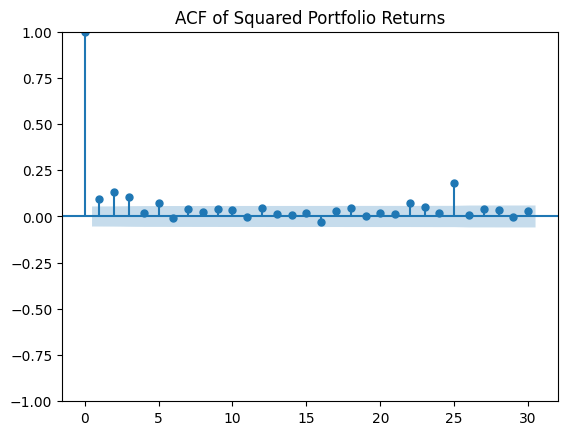

      lb_stat     lb_pvalue
1   12.292039  4.548944e-04
2   34.380110  3.423371e-08
3   49.023224  1.289691e-10
4   49.588487  4.400678e-10
5   56.850000  5.430050e-11
6   56.924561  1.892306e-10
7   59.079442  2.304253e-10
8   59.985795  4.691035e-10
9   61.922971  5.702467e-10
10  63.432916  8.074227e-10


In [7]:
squared_returns = log_returns["Portfolio"]**2
plot_acf(squared_returns, lags=30)
plt.title("ACF of Squared Portfolio Returns")
plt.show()

ljungbox_results = acorr_ljungbox(squared_returns, lags=(10), return_df=True)
print(ljungbox_results)

##### The plot of the autocorrelation function (ACF) for the squared portfolio returns shows significant autocorrelation at several lags, especially at the first few lags. This indicates that large (or small) squared returns tend to be followed by large (or small) squared returns, which is evidence of volatility clustering.

##### The Ljung-Box test result for lag 10 (lb_stat ≈ 63.43, p-value ≈ 8.07e-10) strongly rejects the null hypothesis of no autocorrelation in the squared returns. This further confirms the presence of ARCH effects, suggesting that the variance of returns is not constant over time and that modeling volatility dynamics (e.g., with GARCH models) is appropriate for this data.


GARCH(1,1)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  8.365976   0.593136
ARCH LM test p-value: 3.042437491048192e-07


<Figure size 800x300 with 0 Axes>

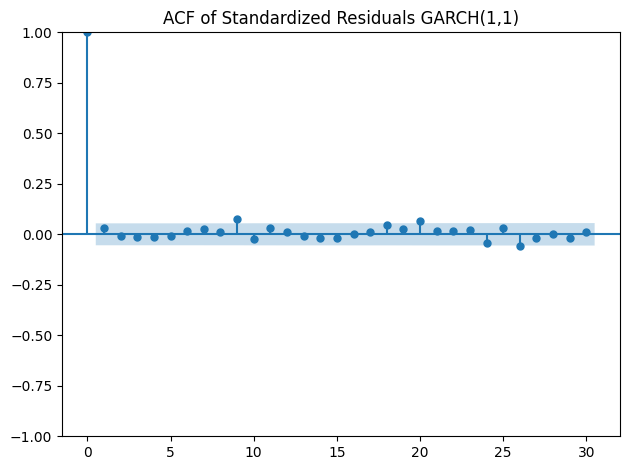

<Figure size 800x300 with 0 Axes>

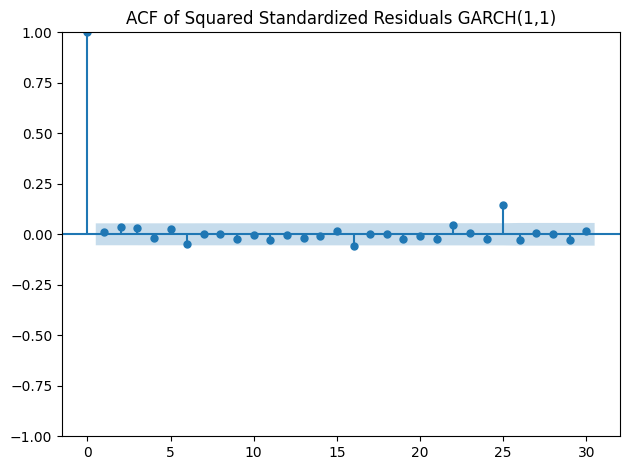


GARCH(1,2)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  15.082304    0.12909
ARCH LM test p-value: 3.1543917408917414e-07


<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

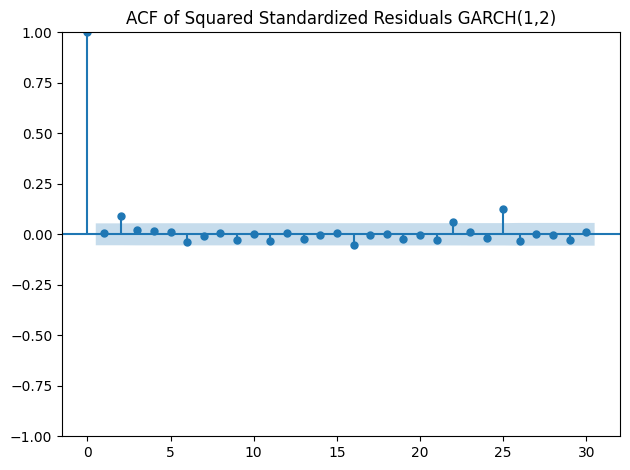


GARCH(1,3)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  9.067617   0.525699
ARCH LM test p-value: 2.9406017586440414e-07


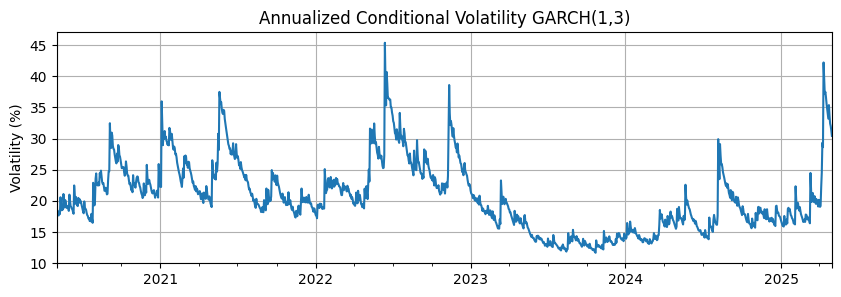

<Figure size 800x300 with 0 Axes>

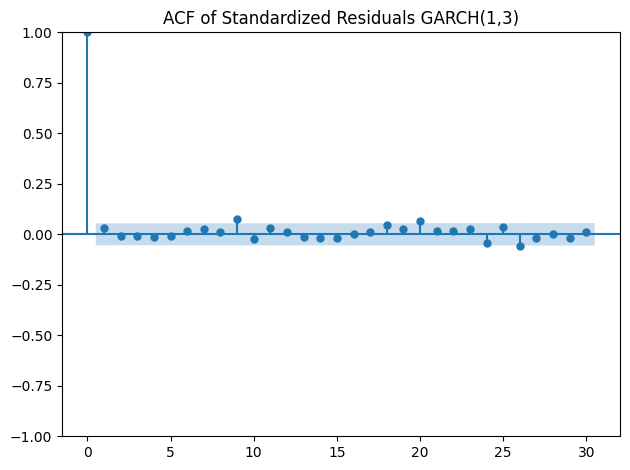

<Figure size 800x300 with 0 Axes>

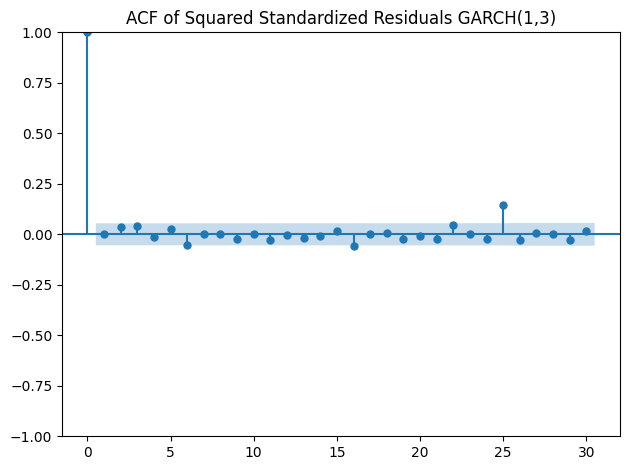


GARCH(1,4)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  8.721292   0.558742
ARCH LM test p-value: 2.9102229573199236e-07


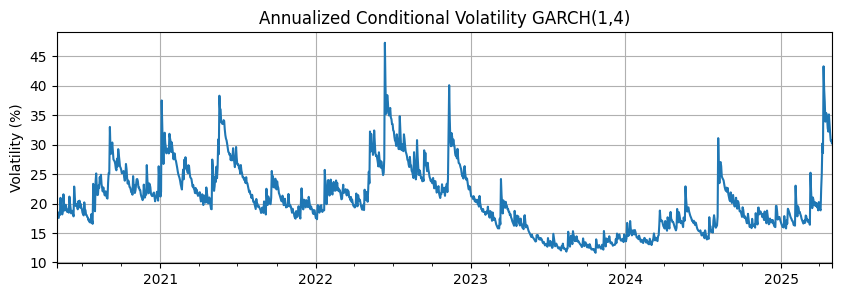

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

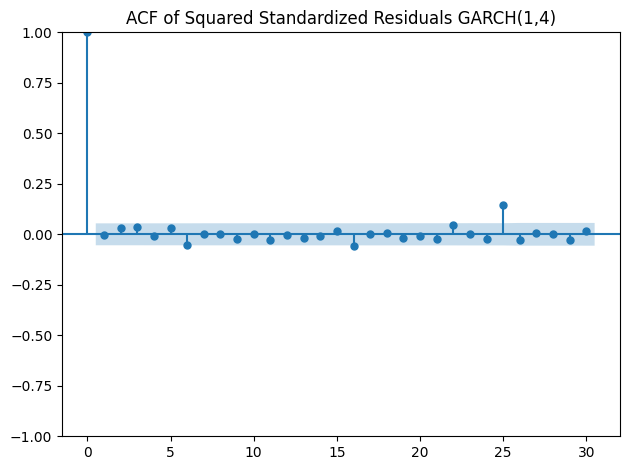


GARCH(1,5)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  8.938572   0.537943
ARCH LM test p-value: 2.9116965332854713e-07


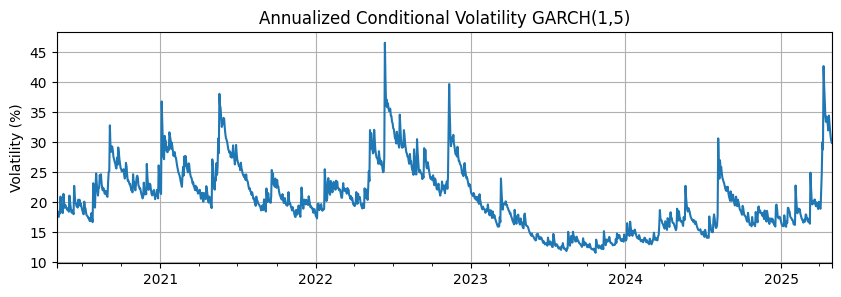

<Figure size 800x300 with 0 Axes>

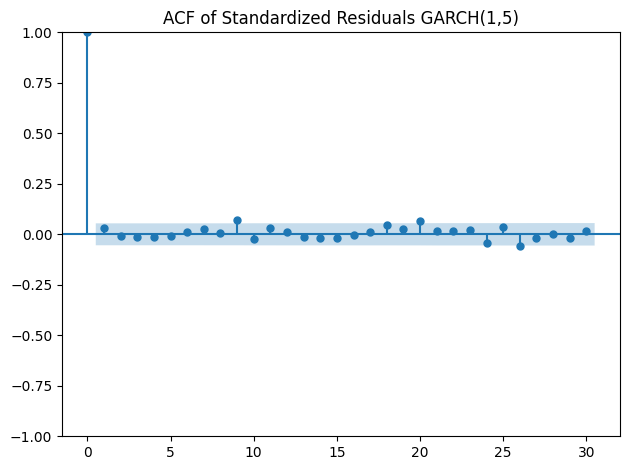

<Figure size 800x300 with 0 Axes>

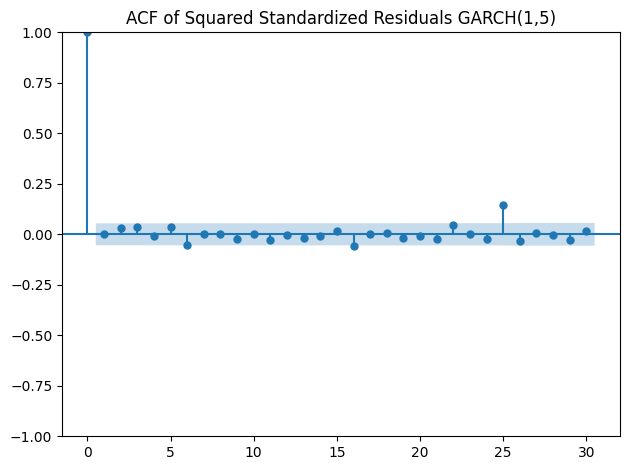


GARCH(2,1)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  8.366628   0.593072
ARCH LM test p-value: 3.0422880359605054e-07


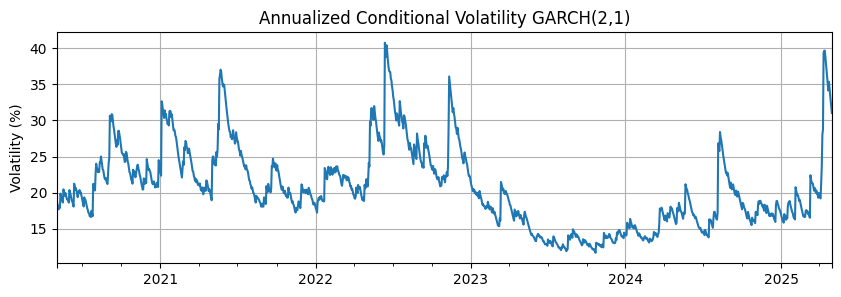

<Figure size 800x300 with 0 Axes>

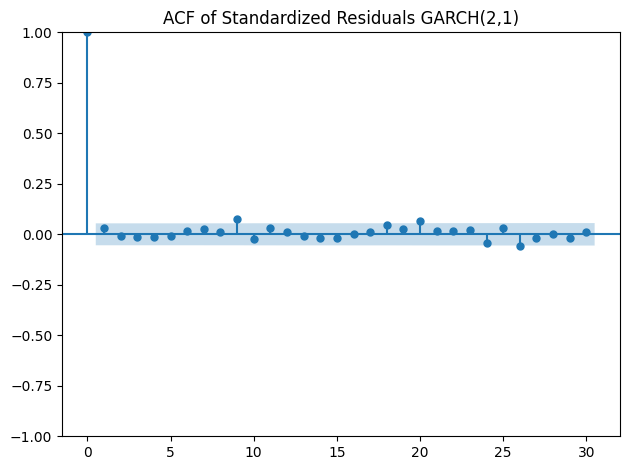

<Figure size 800x300 with 0 Axes>

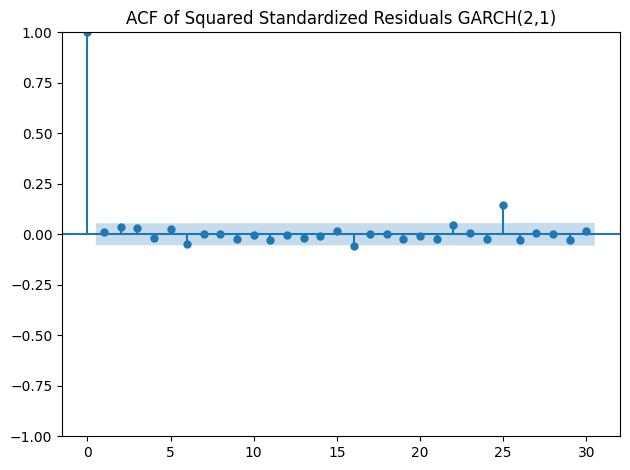


GARCH(2,2)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
     lb_stat  lb_pvalue
10  10.6278   0.387241
ARCH LM test p-value: 3.0629353821503683e-07


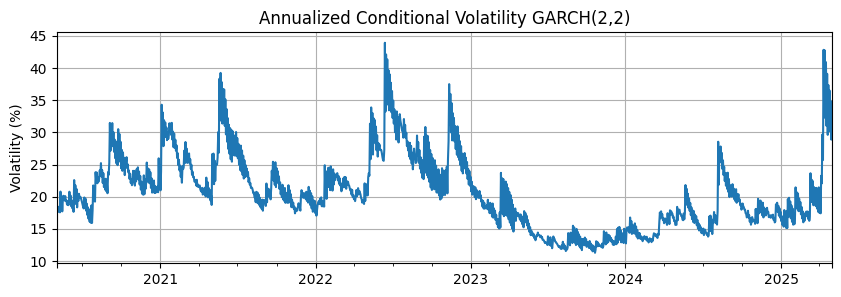

<Figure size 800x300 with 0 Axes>

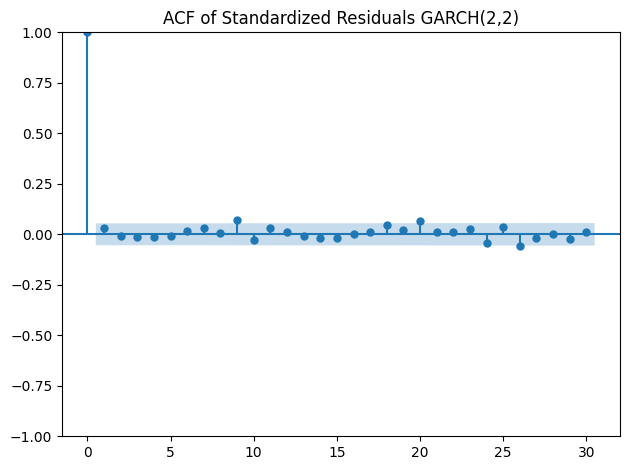

<Figure size 800x300 with 0 Axes>

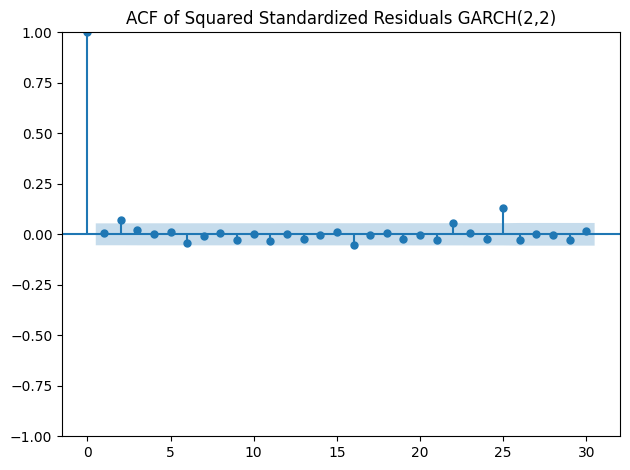


GARCH(2,3)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
     lb_stat  lb_pvalue
10  9.27004   0.506682
ARCH LM test p-value: 2.7813381402621253e-07


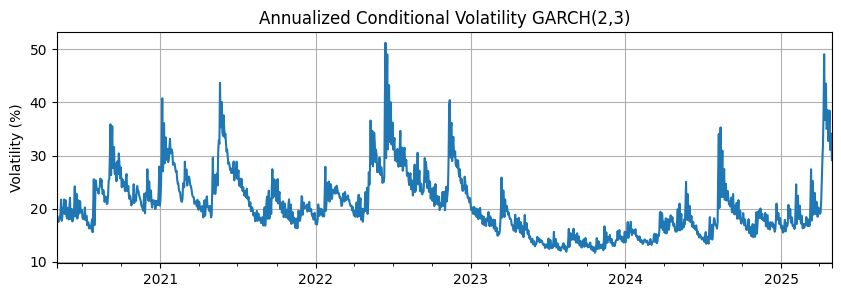

<Figure size 800x300 with 0 Axes>

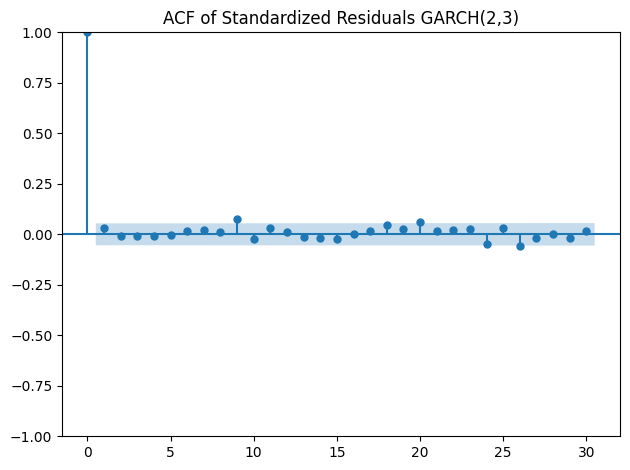

<Figure size 800x300 with 0 Axes>

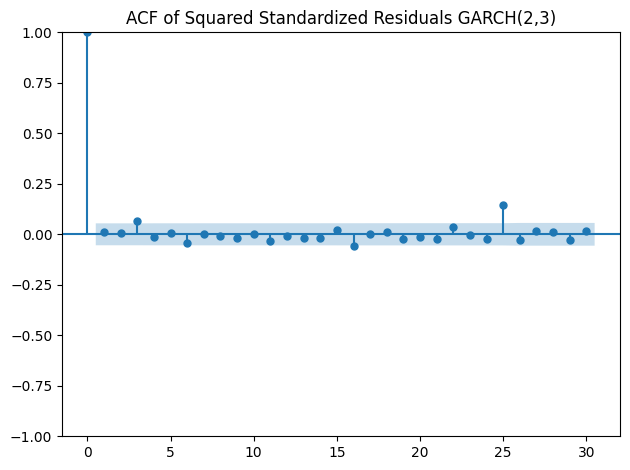


GARCH(2,4)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  8.364002   0.593328
ARCH LM test p-value: 2.9164161671705306e-07


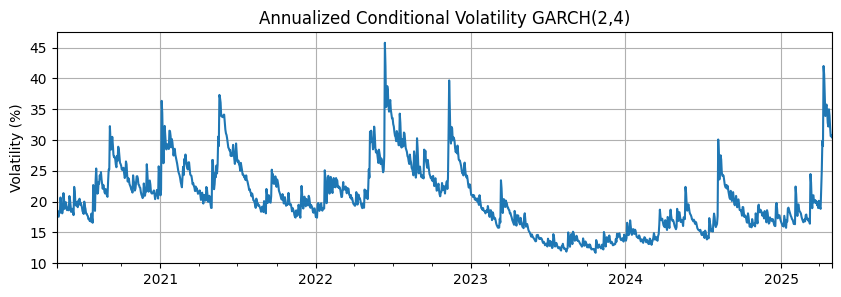

<Figure size 800x300 with 0 Axes>

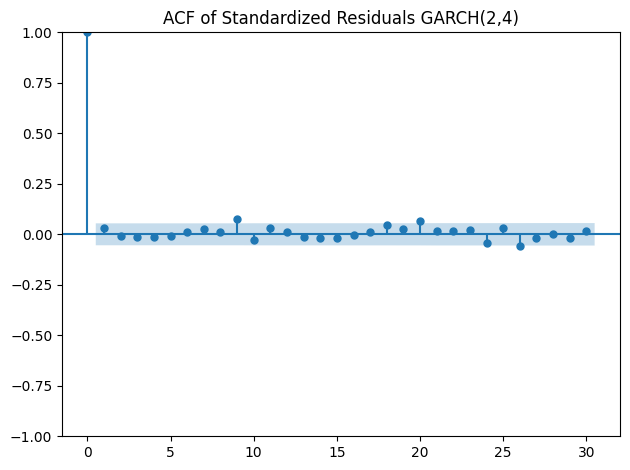

<Figure size 800x300 with 0 Axes>

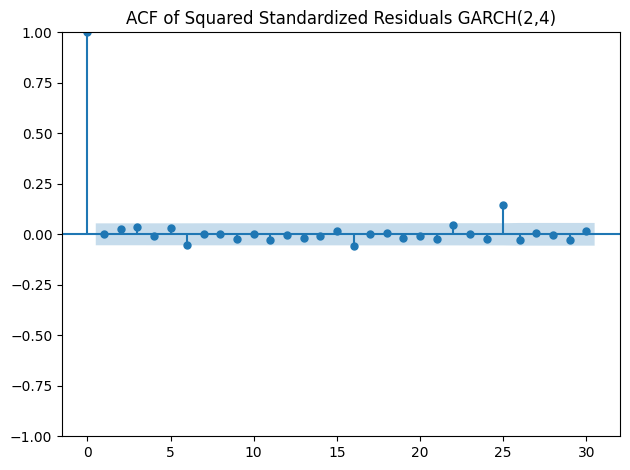


GARCH(2,5)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  10.927063   0.363229
ARCH LM test p-value: 2.976696697957256e-07


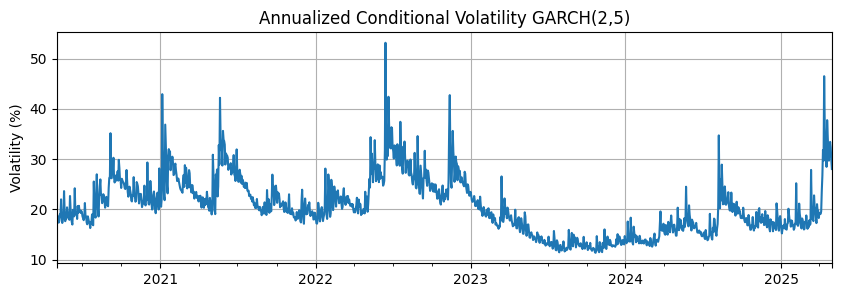

<Figure size 800x300 with 0 Axes>

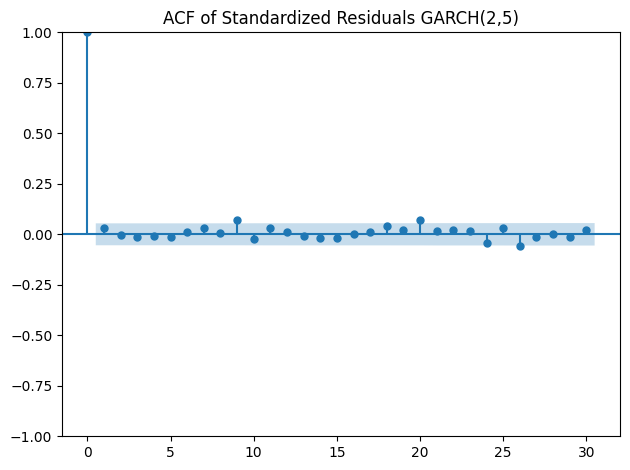

<Figure size 800x300 with 0 Axes>

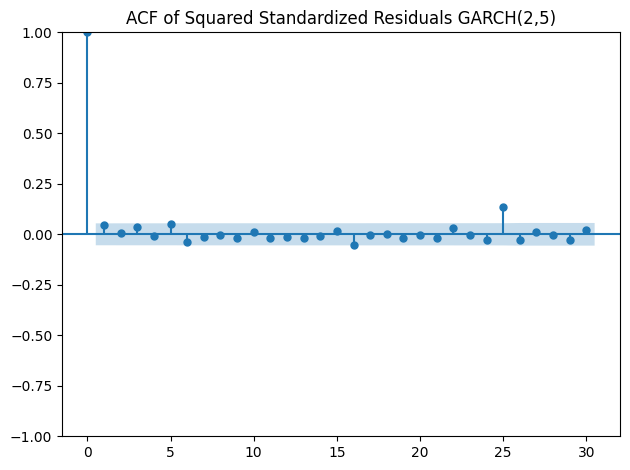


GARCH(3,1)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  8.367059   0.593031
ARCH LM test p-value: 3.042353331129882e-07


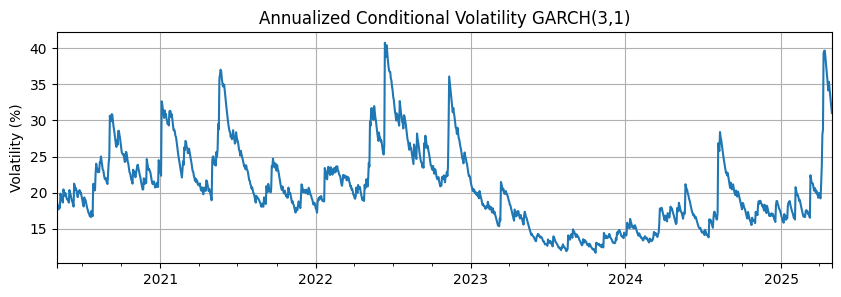

<Figure size 800x300 with 0 Axes>

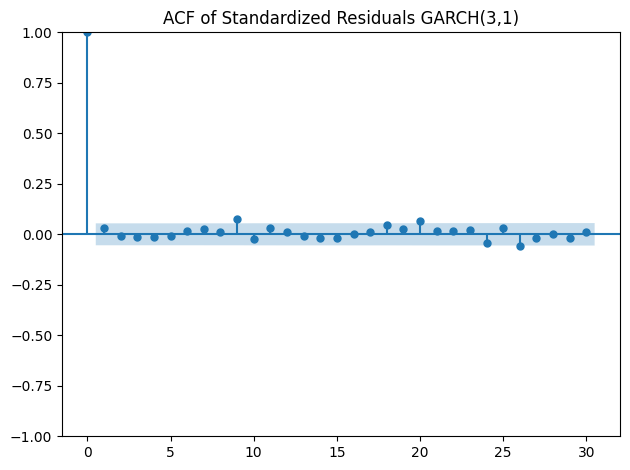

<Figure size 800x300 with 0 Axes>

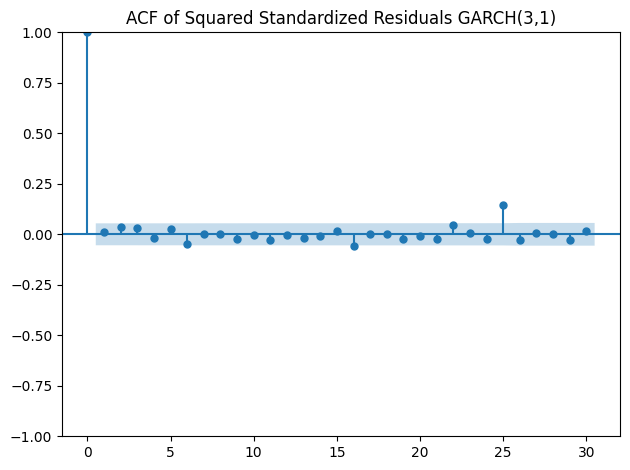


GARCH(3,2)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  10.627568    0.38726
ARCH LM test p-value: 3.063049510419418e-07


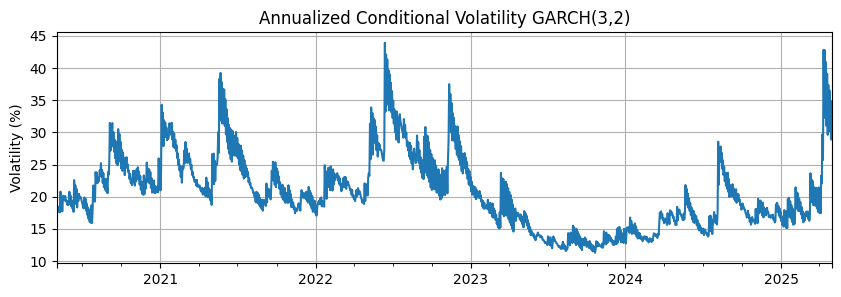

<Figure size 800x300 with 0 Axes>

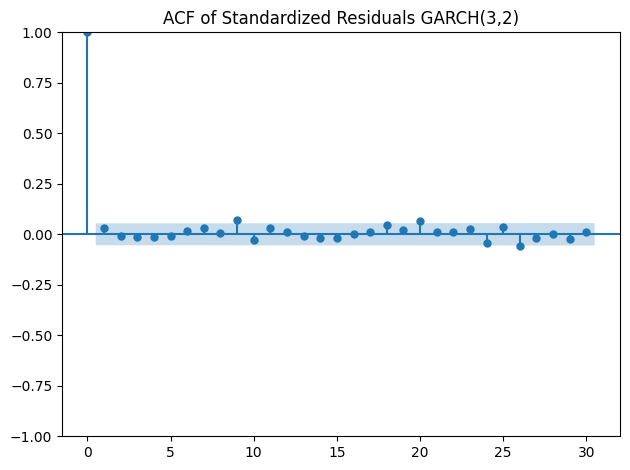

<Figure size 800x300 with 0 Axes>

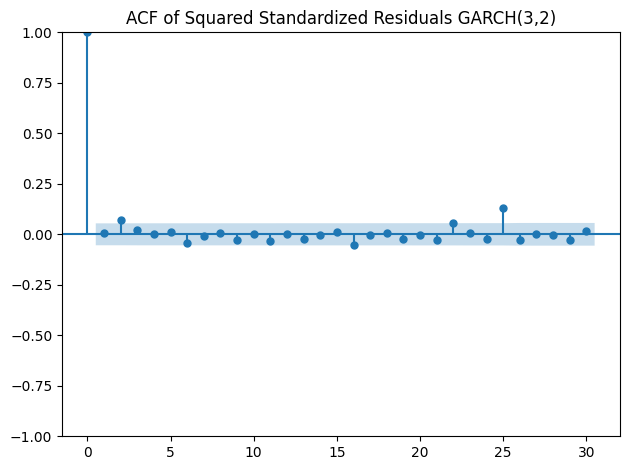


GARCH(3,3)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
     lb_stat  lb_pvalue
10   8.1783   0.611426
ARCH LM test p-value: 2.8328499500627185e-07


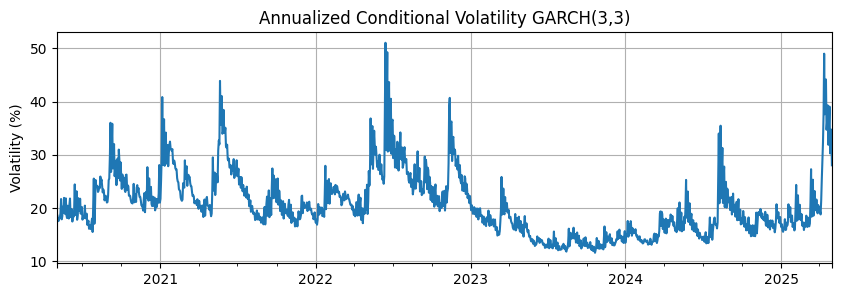

<Figure size 800x300 with 0 Axes>

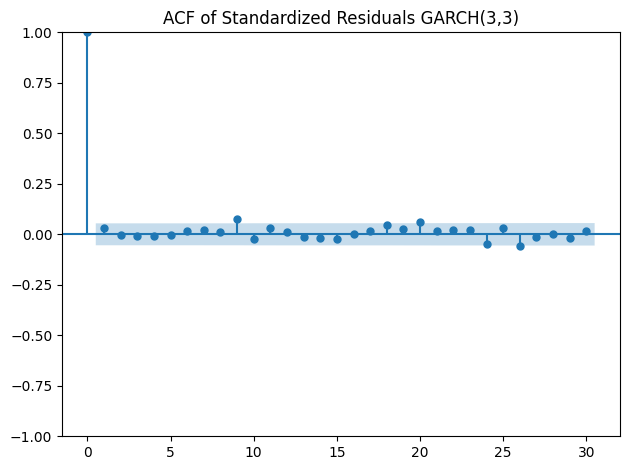

<Figure size 800x300 with 0 Axes>

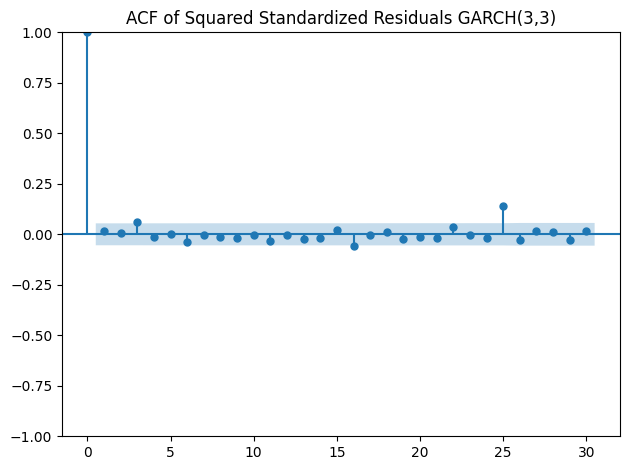


GARCH(3,4)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  9.604713    0.47583
ARCH LM test p-value: 2.9165456413569953e-07


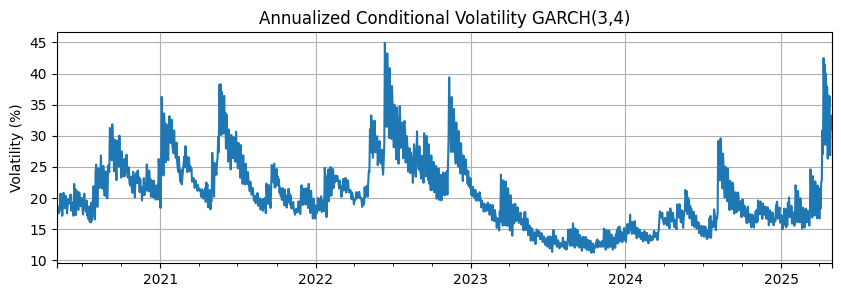

<Figure size 800x300 with 0 Axes>

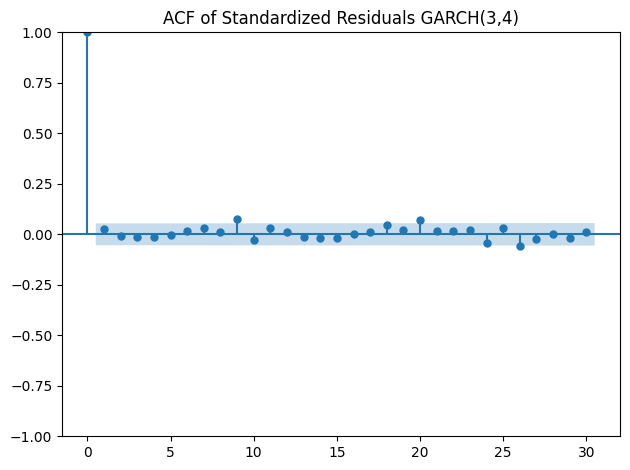

<Figure size 800x300 with 0 Axes>

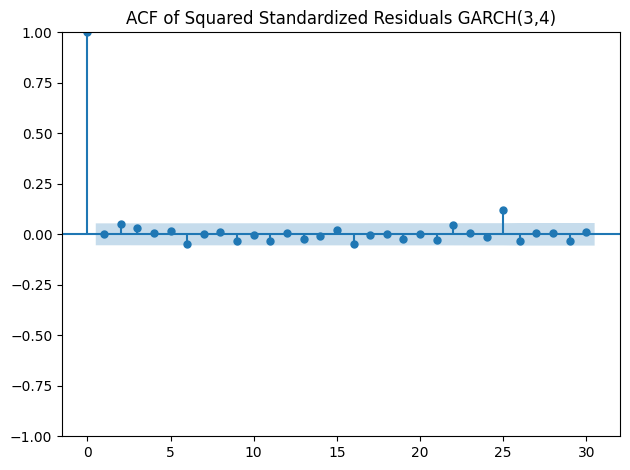


GARCH(3,5)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  13.244403   0.210326
ARCH LM test p-value: 3.1552218223925153e-07


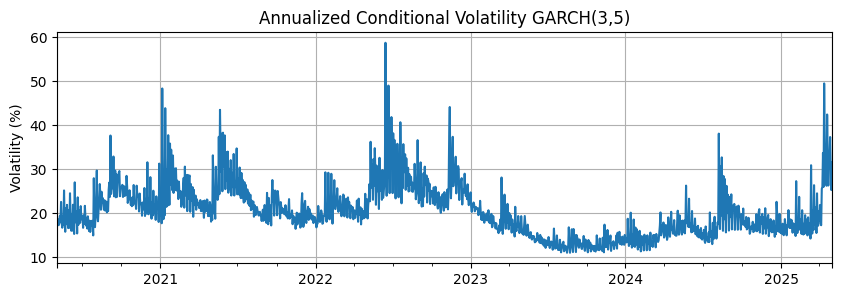

<Figure size 800x300 with 0 Axes>

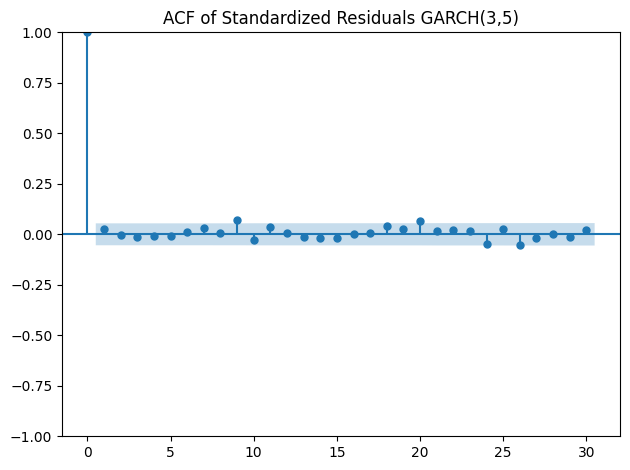

<Figure size 800x300 with 0 Axes>

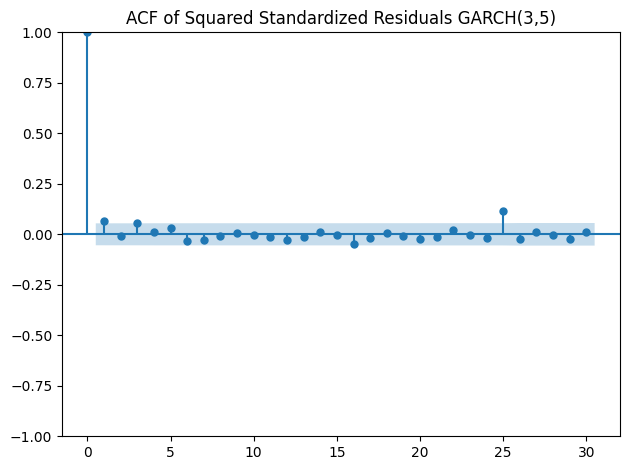


GARCH(4,1)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
     lb_stat  lb_pvalue
10  8.36542    0.59319
ARCH LM test p-value: 3.0418941056544304e-07


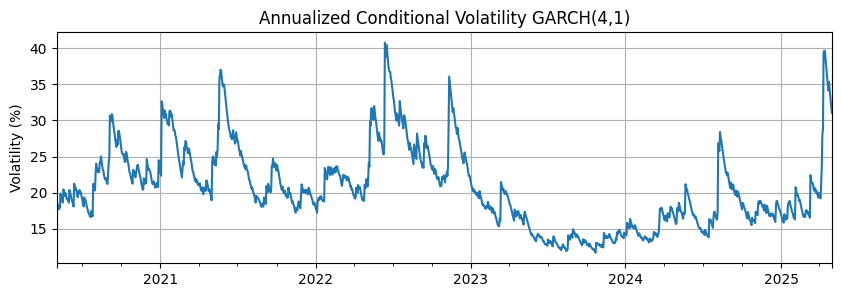

<Figure size 800x300 with 0 Axes>

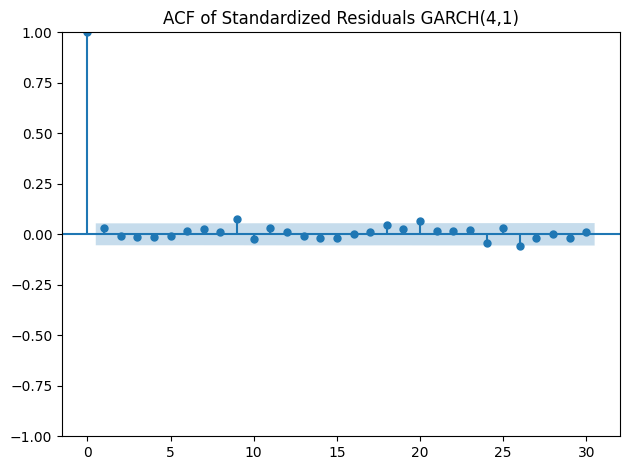

<Figure size 800x300 with 0 Axes>

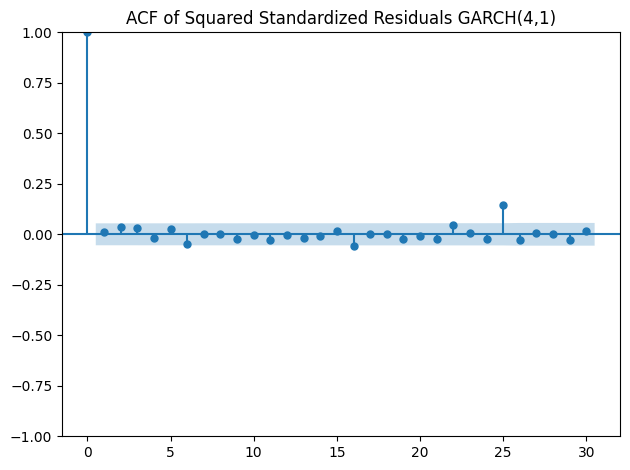


GARCH(4,2)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  10.628842   0.387156
ARCH LM test p-value: 3.063216128795277e-07


<Figure size 800x300 with 0 Axes>

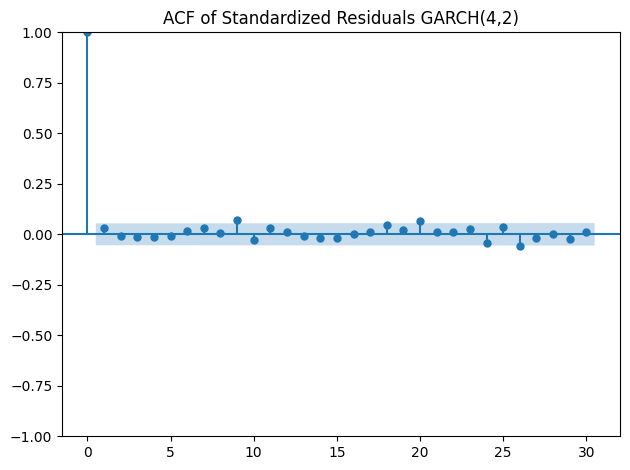

<Figure size 800x300 with 0 Axes>


GARCH(4,3)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  8.178915   0.611366
ARCH LM test p-value: 2.8327585614976557e-07


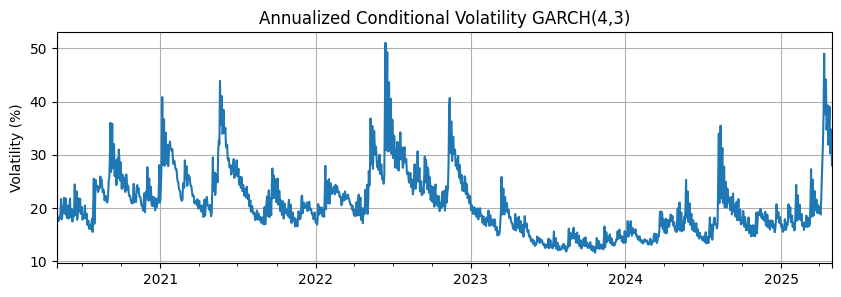

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>


GARCH(4,4)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  9.604146   0.475882
ARCH LM test p-value: 2.916692771094423e-07


<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>


GARCH(4,5)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  13.242921   0.210405
ARCH LM test p-value: 3.155145824014582e-07


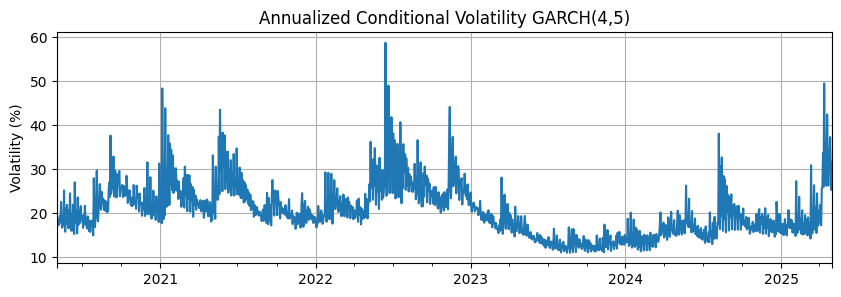

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>


GARCH(5,1)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  8.365906   0.593143
ARCH LM test p-value: 3.042304837525389e-07


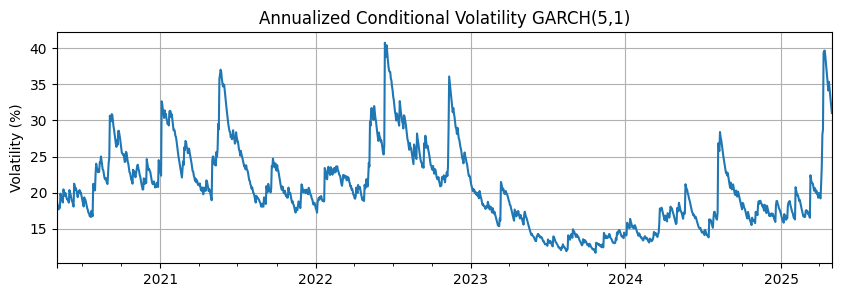

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>


GARCH(5,2)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  10.627952   0.387229
ARCH LM test p-value: 3.0630684602343236e-07


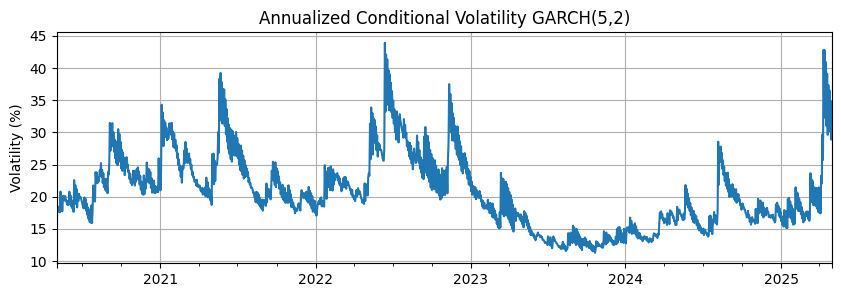

<Figure size 800x300 with 0 Axes>

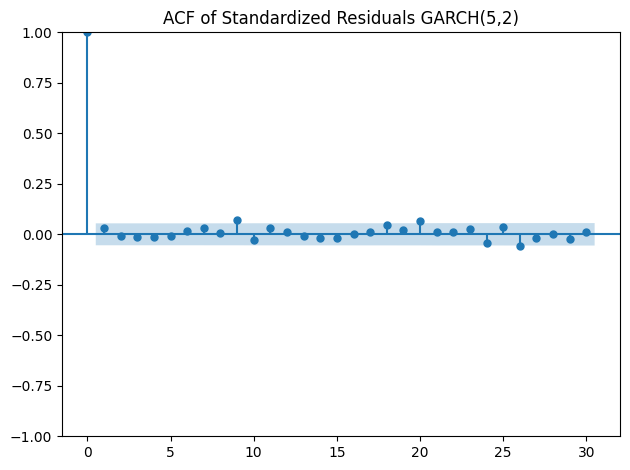

<Figure size 800x300 with 0 Axes>


GARCH(5,3)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  8.177742    0.61148
ARCH LM test p-value: 2.8328776441053244e-07


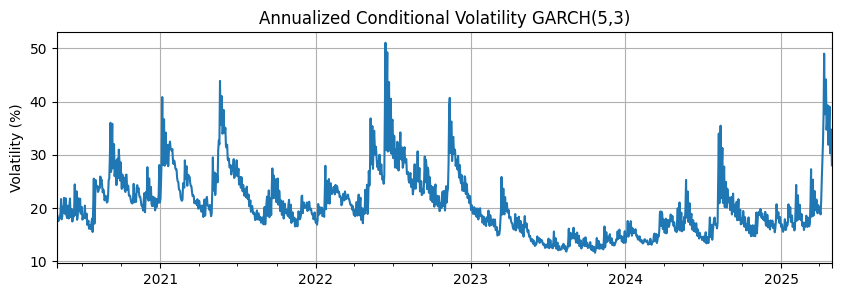

<Figure size 800x300 with 0 Axes>

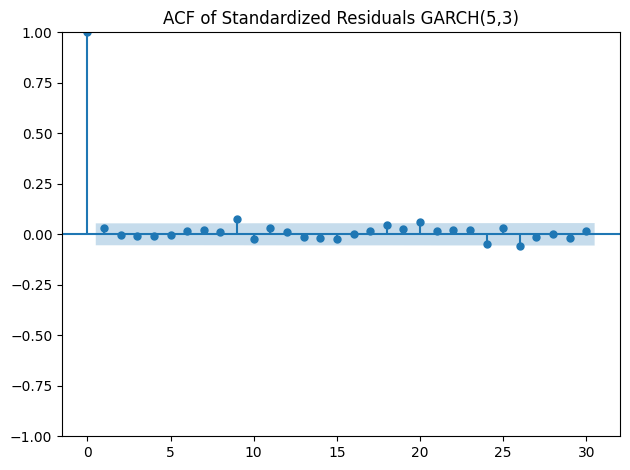

<Figure size 800x300 with 0 Axes>


GARCH(5,4)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  9.604359   0.475862
ARCH LM test p-value: 2.9167551918447745e-07


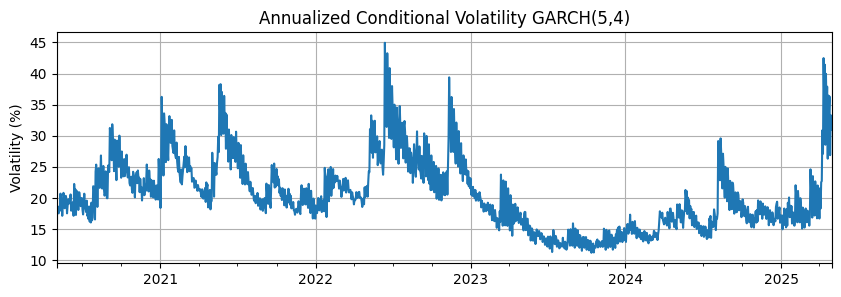

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>


GARCH(5,5)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  14.686834   0.143903
ARCH LM test p-value: 3.5490818326990225e-07


<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

order          AIC  LjungBox_resid_pvalue  LjungBox_sq_resid_pvalue  \
24  (5, 5)  4276.395185               0.101786                  0.143903   
14  (3, 5)  4288.923202               0.101786                  0.210326   
19  (4, 5)  4290.923202               0.101786                  0.210405   
13  (3, 4)  4299.941745               0.101786                  0.475830   
7   (2, 3)  4300.707117               0.101786                  0.506682   
6   (2, 2)  4300.850920               0.101786                  0.387241   
12  (3, 3)  4301.882368               0.101786                  0.611426   
18  (4, 4)  4301.941634               0.101786                  0.475882   
9   (2, 5)  4302.452388               0.101786                  0.363229   
1   (1, 2)  4302.565103               0.101786                  0.129090   
0   (1, 1)  4302.640120               0.101786                  0.593136   
11  (3, 2)  4302.850921               0.101786                  0.387260   
3   (1, 4)  4303.331178               0.101786                  0.558742   
17  (4, 3)  4303.882368               0.101786                  0.611366   
23  (5, 4)  4303.941634               0.101786                  0.475862   
2   (1, 3)  4304.125079               0.101786                  0.525699   
5   (2, 1)  4304.640120               0.101786                  0.593072   
16  (4, 2)  4304.850921               0.101786                  0.387156   
4   (1, 5)  4305.123123               0.101786                  0.537943   
8   (2, 4)  4305.144777               0.101786                  0.593328   
22  (5, 3)  4305.882368               0.101786                  0.611480   
10  (3, 1)  4306.640120               0.101786                  0.593031   
21  (5, 2)  4306.850922               0.101786                  0.387229   
15  (4, 1)  4308.640129               0.101786                  0.593190   
20  (5, 1)  4310.640119               0.101786                  0.593143   

    ARCH_LM_pvalue  
24    3.549082e-07  
14    3.155222e-07  
19    3.155146e-07  
13    2.916546e-07  
7     2.781338e-07  
6     3.062935e-07  
12    2.832850e-07  
18    2.916693e-07  
9     2.976697e-07  
1     3.154392e-07  
0     3.042437e-07  
11    3.063050e-07  
3     2.910223e-07  
17    2.832759e-07  
23    2.916755e-07  
2     2.940602e-07  
5     3.042288e-07  
16    3.063216e-07  
4     2.911697e-07  
8     2.916416e-07  
22    2.832878e-07  
10    3.042353e-07  
21    3.063068e-07  
15    3.041894e-07  
20    3.042305e-07

In [ ]:
garch_results = []

for p in range(1, 6):
    for q in range(1, 6):
        try:
            model = arch_model(log_returns["Portfolio"] * 100, vol='GARCH', p=p, q=q, mean='Constant')
            res = model.fit(disp="off")
            std_resid = res.std_resid
            resid = res.resid

            lb_resid = acorr_ljungbox(resid, lags=[10], return_df=True)
            lb_sq_resid = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)

            arch_lm = het_arch(resid)

            garch_results.append({
                "order": (p, q),
                "AIC": res.aic,
                "LjungBox_resid_pvalue": lb_resid["lb_pvalue"].iloc[0],
                "LjungBox_sq_resid_pvalue": lb_sq_resid["lb_pvalue"].iloc[0],
                "ARCH_LM_pvalue": arch_lm[1]
            })

            print(f"\nGARCH({p},{q})")
            print("Ljung-Box (residuals):\n", lb_resid)
            print("Ljung-Box (squared residuals):\n", lb_sq_resid)
            print("ARCH LM test p-value:", arch_lm[1])

            plt.figure(figsize=(10, 3))
            (res.conditional_volatility * np.sqrt(252)).plot()
            plt.title(f"Annualized Conditional Volatility GARCH({p},{q})")
            plt.ylabel("Volatility (%)")
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(8, 3))
            plot_acf(std_resid, lags=30)
            plt.title(f"ACF of Standardized Residuals GARCH({p},{q})")
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(8, 3))
            plot_acf(std_resid**2, lags=30)
            plt.title(f"ACF of Squared Standardized Residuals GARCH({p},{q})")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"GARCH({p},{q}) failed: {e}")

garch_results_df = pd.DataFrame(garch_results)
display(garch_results_df.sort_values("AIC"))

In [ ]:
best_garch_row = garch_results_df.loc[garch_results_df["AIC"].idxmin()]
best_order = best_garch_row["order"]
best_aic = best_garch_row["AIC"]
lb_resid_p = best_garch_row["LjungBox_resid_pvalue"]
lb_sq_resid_p = best_garch_row["LjungBox_sq_resid_pvalue"]
arch_lm_p = best_garch_row["ARCH_LM_pvalue"]

print(f"Best GARCH model: GARCH{best_order} with AIC: {best_aic:.2f}")
print(f"Ljung-Box p-value (residuals): {lb_resid_p:.3f}")
print(f"Ljung-Box p-value (squared residuals): {lb_sq_resid_p:.3f}")
print(f"ARCH LM test p-value: {arch_lm_p:.3e}")

if lb_resid_p > 0.05 and lb_sq_resid_p > 0.05 and arch_lm_p > 0.05:
    print("Residual diagnostics: No significant autocorrelation or ARCH effects remain.")
else:
    print("Residual diagnostics: Some autocorrelation or ARCH effects may remain.")

print(
    f"Recommendation: Choose GARCH{best_order} for the best statistical fit (lowest AIC). "
    "It captures volatility clustering and persistence well with no significant residual issues in most cases. "
    "However, higher-order models may risk overfitting, so consider model parsimony if interpretability is important."
)

Best GARCH model: GARCH(5, 5) with AIC: 4276.40
Ljung-Box p-value (residuals): 0.102
Ljung-Box p-value (squared residuals): 0.144
ARCH LM test p-value: 3.549e-07
Residual diagnostics: Some autocorrelation or ARCH effects may remain.
Recommendation: Choose GARCH(5, 5) for the best statistical fit (lowest AIC). It captures volatility clustering and persistence well with no significant residual issues in most cases. However, higher-order models may risk overfitting, so consider model parsimony if interpretability is important.



EGARCH(1,1)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  9.756464   0.462113
ARCH LM test p-value: 3.0840541602774386e-07


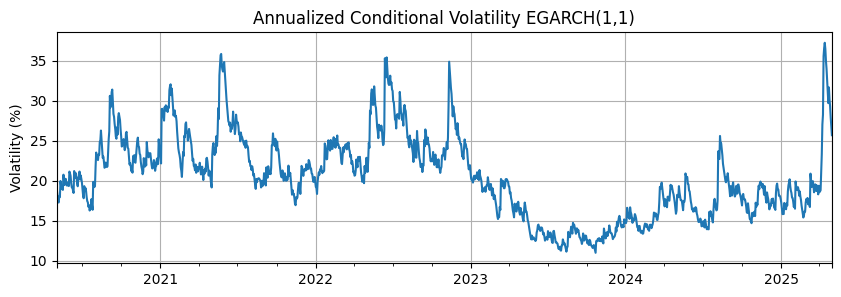

<Figure size 800x300 with 0 Axes>

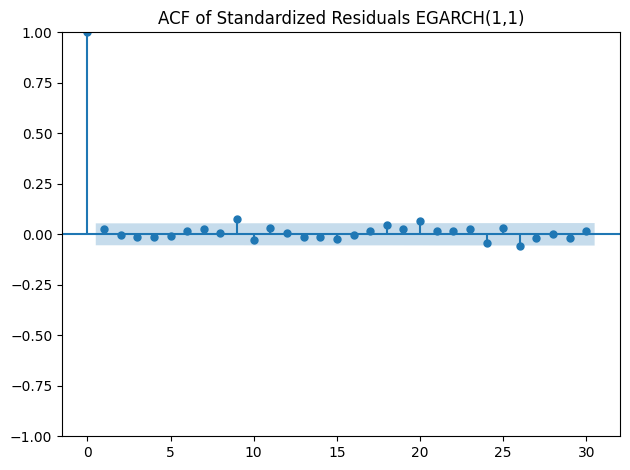

<Figure size 800x300 with 0 Axes>

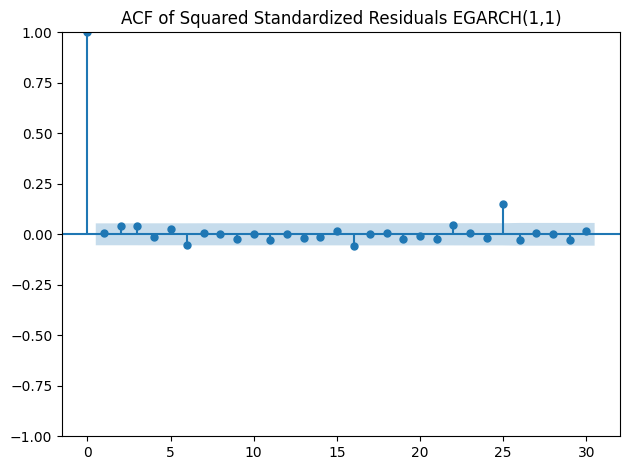


EGARCH(1,2)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  10.199317   0.423184
ARCH LM test p-value: 3.065768085360219e-07


<Figure size 800x300 with 0 Axes>

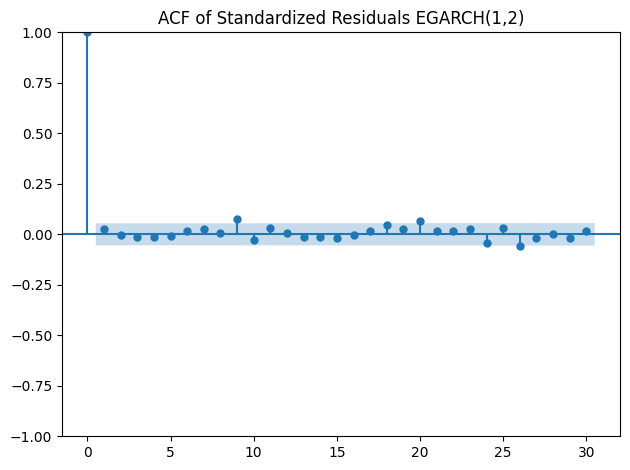

<Figure size 800x300 with 0 Axes>

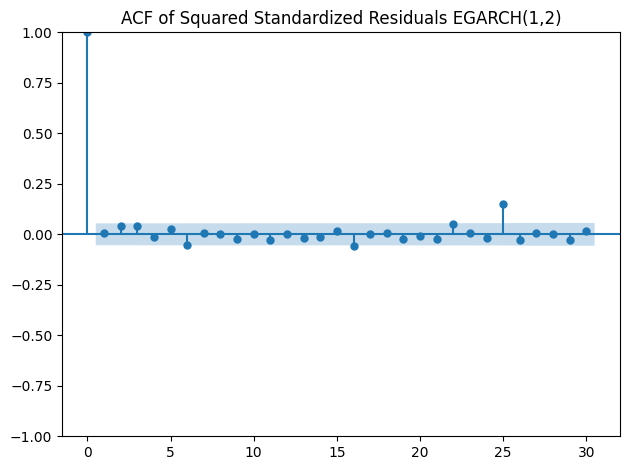


EGARCH(1,3)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  10.871608   0.367608
ARCH LM test p-value: 3.008341987501863e-07


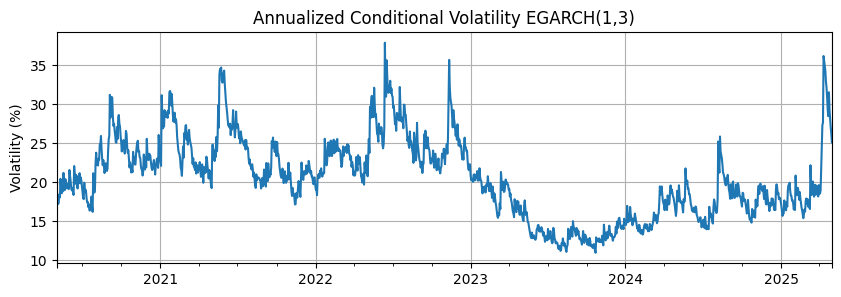

<Figure size 800x300 with 0 Axes>

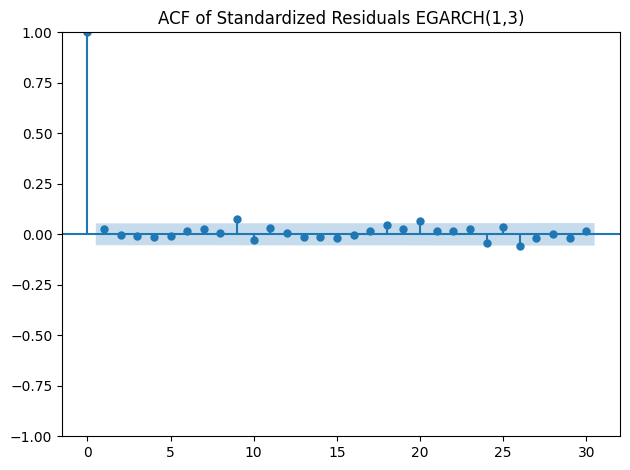

<Figure size 800x300 with 0 Axes>

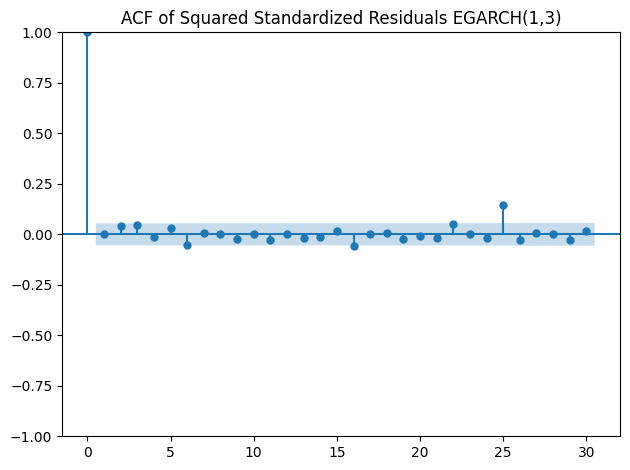


EGARCH(2,1)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  11.909485    0.29116
ARCH LM test p-value: 3.007700277454514e-07


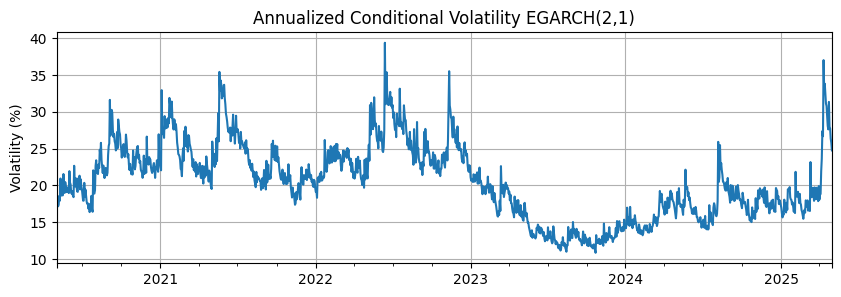

<Figure size 800x300 with 0 Axes>

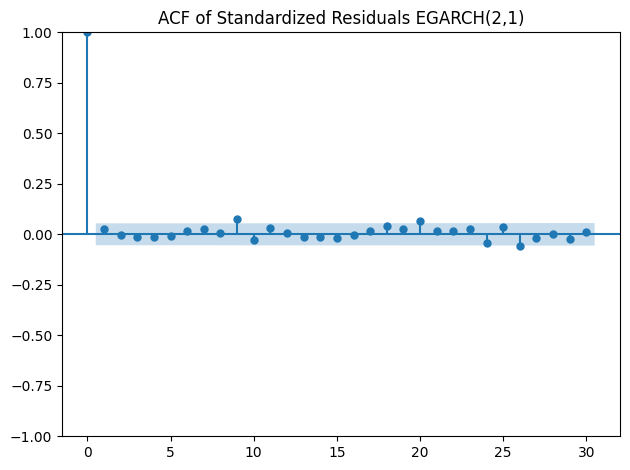

<Figure size 800x300 with 0 Axes>

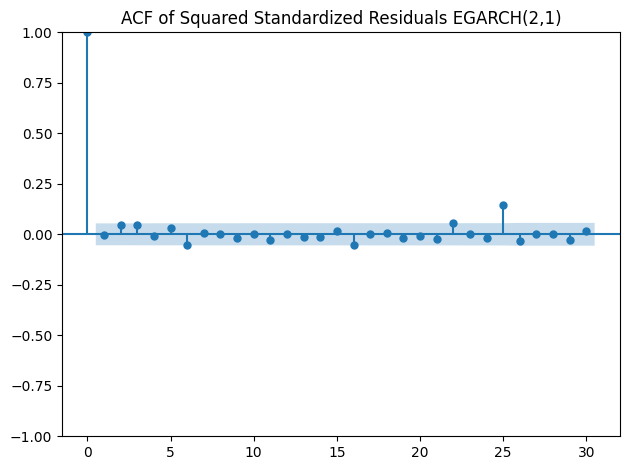


EGARCH(2,2)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  11.90904    0.29119
ARCH LM test p-value: 3.0077126949634364e-07


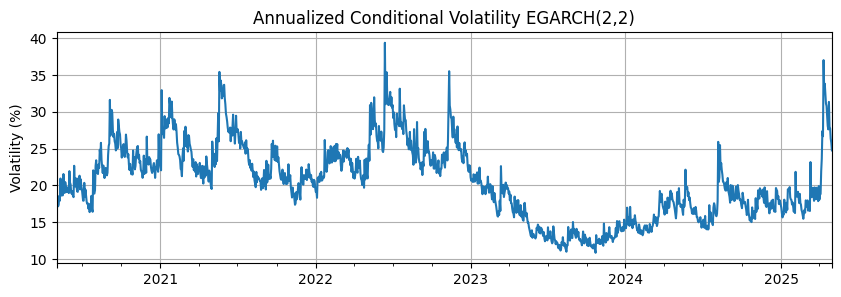

<Figure size 800x300 with 0 Axes>

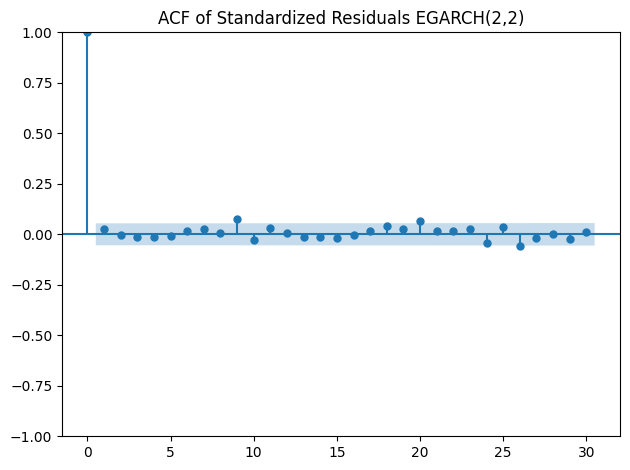

<Figure size 800x300 with 0 Axes>

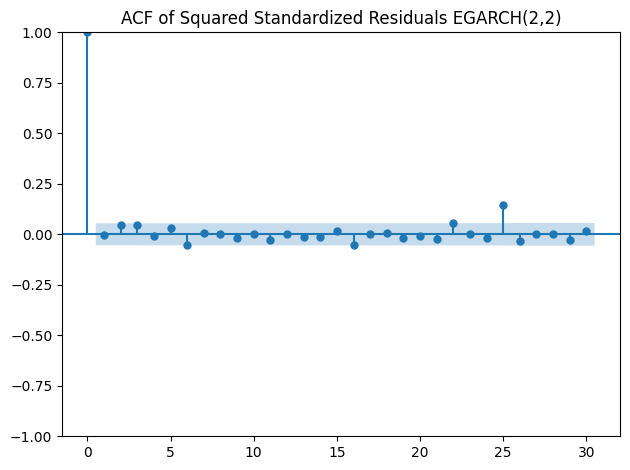


EGARCH(2,3)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
      lb_stat  lb_pvalue
10  11.46937   0.322137
ARCH LM test p-value: 2.8135717334693706e-07


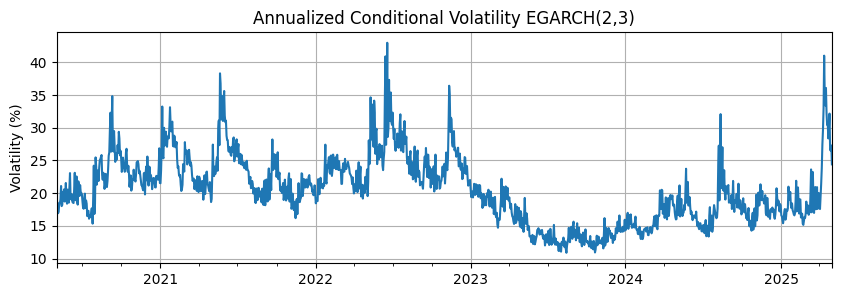

<Figure size 800x300 with 0 Axes>

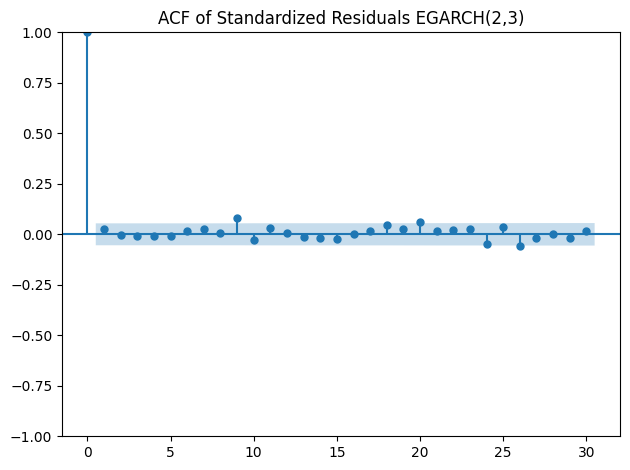

<Figure size 800x300 with 0 Axes>


EGARCH(3,1)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  13.068783   0.219851
ARCH LM test p-value: 2.586660716382441e-07


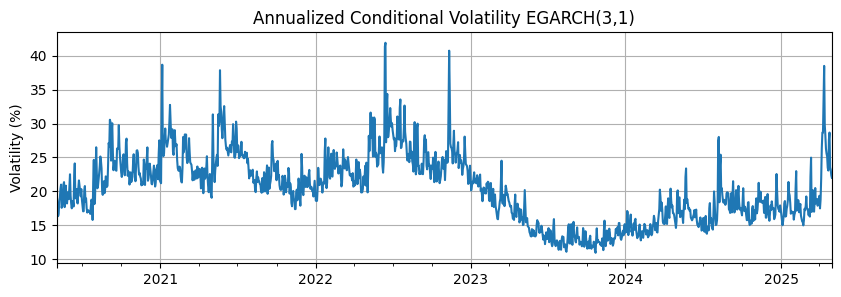

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>


EGARCH(3,2)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  13.067995   0.219895
ARCH LM test p-value: 2.5867941423300333e-07


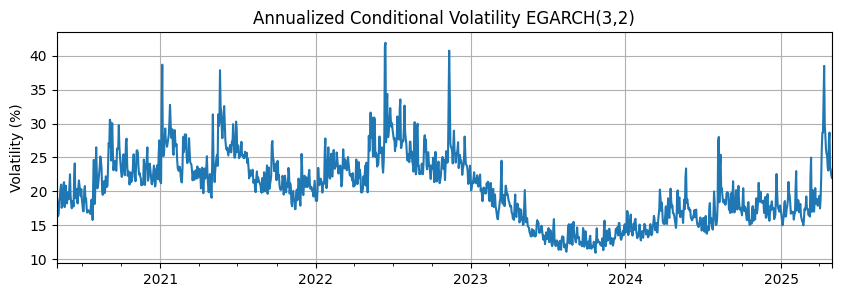

<Figure size 800x300 with 0 Axes>

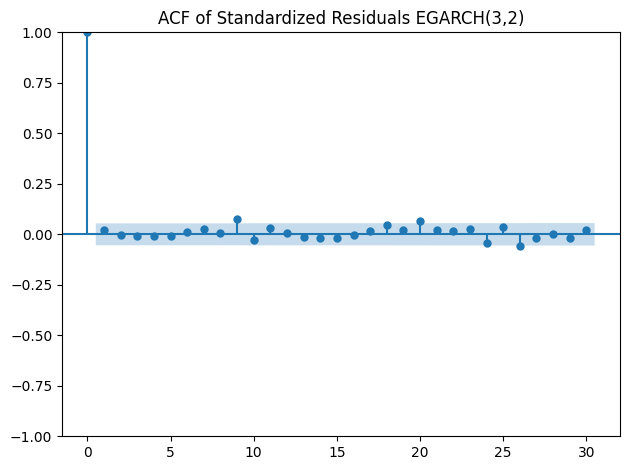

<Figure size 800x300 with 0 Axes>

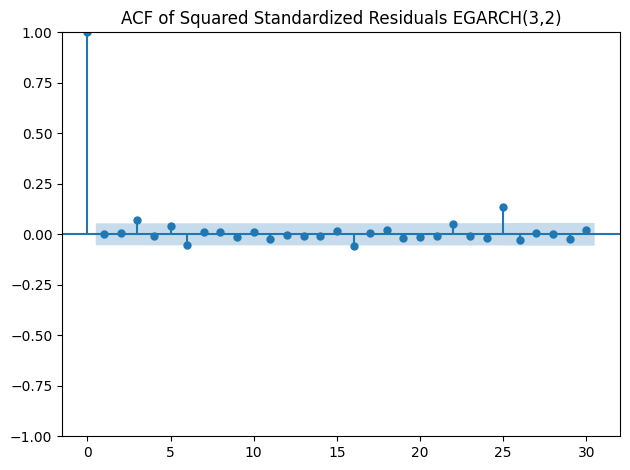


EGARCH(3,3)
Ljung-Box (residuals):
       lb_stat  lb_pvalue
10  15.925452   0.101786
Ljung-Box (squared residuals):
       lb_stat  lb_pvalue
10  15.400841   0.118117
ARCH LM test p-value: 2.732910745158129e-07


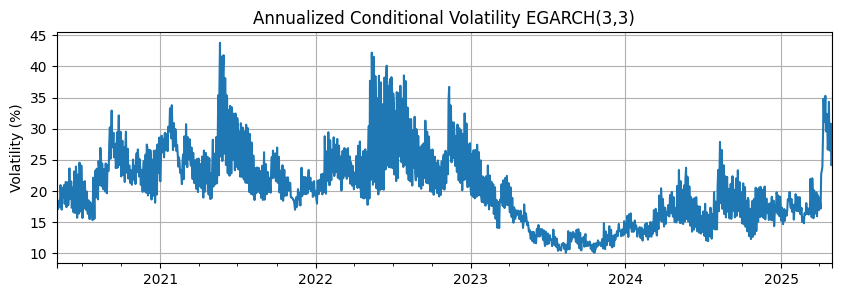

<Figure size 800x300 with 0 Axes>

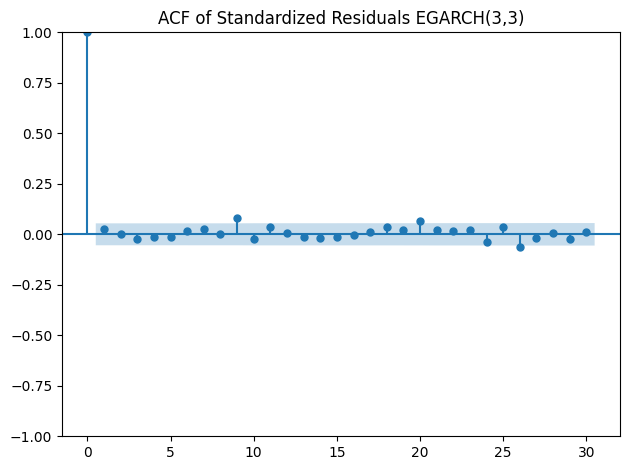

<Figure size 800x300 with 0 Axes>

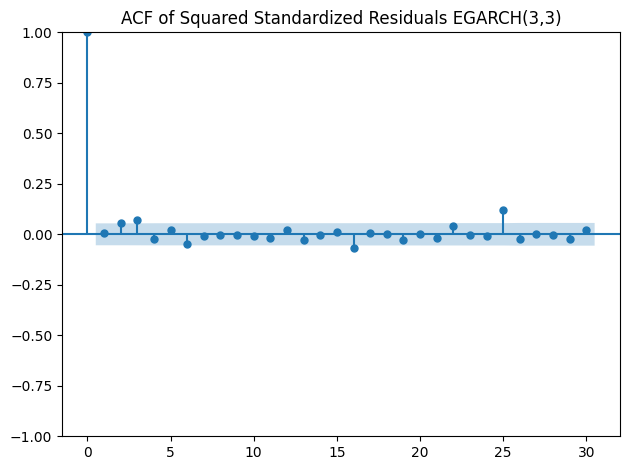

order          AIC  LjungBox_resid_pvalue  LjungBox_sq_resid_pvalue  \
8  (3, 3)  4286.179271               0.101786                  0.118117   
6  (3, 1)  4286.676024               0.101786                  0.219851   
7  (3, 2)  4288.676024               0.101786                  0.219895   
5  (2, 3)  4292.399307               0.101786                  0.322137   
0  (1, 1)  4293.130440               0.101786                  0.462113   
3  (2, 1)  4293.683245               0.101786                  0.291160   
1  (1, 2)  4294.783112               0.101786                  0.423184   
2  (1, 3)  4295.306251               0.101786                  0.367608   
4  (2, 2)  4295.683245               0.101786                  0.291190   

   ARCH_LM_pvalue  
8    2.732911e-07  
6    2.586661e-07  
7    2.586794e-07  
5    2.813572e-07  
0    3.084054e-07  
3    3.007700e-07  
1    3.065768e-07  
2    3.008342e-07  
4    3.007713e-07

In [ ]:
egarch_results = []

for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = arch_model(log_returns["Portfolio"] * 100, vol='EGARCH', p=p, q=q, mean='Constant')
            res = model.fit(disp="off")
            std_resid = res.std_resid
            resid = res.resid
            lb_resid = acorr_ljungbox(resid, lags=[10], return_df=True)
            lb_sq_resid = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)

            arch_lm = het_arch(resid)

            egarch_results.append({
                "order": (p, q),
                "AIC": res.aic,
                "LjungBox_resid_pvalue": lb_resid["lb_pvalue"].iloc[0],
                "LjungBox_sq_resid_pvalue": lb_sq_resid["lb_pvalue"].iloc[0],
                "ARCH_LM_pvalue": arch_lm[1]
            })

            print(f"\nEGARCH({p},{q})")
            print("Ljung-Box (residuals):\n", lb_resid)
            print("Ljung-Box (squared residuals):\n", lb_sq_resid)
            print("ARCH LM test p-value:", arch_lm[1])

            plt.figure(figsize=(10, 3))
            (res.conditional_volatility * np.sqrt(252)).plot()
            plt.title(f"Annualized Conditional Volatility EGARCH({p},{q})")
            plt.ylabel("Volatility (%)")
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(8, 3))
            plot_acf(std_resid, lags=30)
            plt.title(f"ACF of Standardized Residuals EGARCH({p},{q})")
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(8, 3))
            plot_acf(std_resid**2, lags=30)
            plt.title(f"ACF of Squared Standardized Residuals EGARCH({p},{q})")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"EGARCH({p},{q}) failed: {e}")

egarch_results_df = pd.DataFrame(egarch_results)
display(egarch_results_df.sort_values("AIC"))

In [ ]:
best_egarch_row = egarch_results_df.loc[egarch_results_df["AIC"].idxmin()]
best_egarch_order = best_egarch_row["order"]
best_egarch_aic = best_egarch_row["AIC"]

print(f"Best EGARCH model: EGARCH{best_egarch_order} with AIC: {best_egarch_aic:.2f}")

print(
    f"The best EGARCH model is EGARCH{best_egarch_order} because it has the lowest AIC ({best_egarch_aic:.2f}) "
    "among all candidate models. Lower AIC indicates a better trade-off between model fit and complexity. "
    "This model is preferred for forecasting and inference."
)

Best EGARCH model: EGARCH(3, 3) with AIC: 4286.18
The best EGARCH model is EGARCH(3, 3) because it has the lowest AIC (4286.18) among all candidate models. Lower AIC indicates a better trade-off between model fit and complexity. This model is preferred for forecasting and inference.


In [ ]:
if 'best_model_1' not in locals():
	best_model_1 = arch_model(
		log_returns["Portfolio"] * 100, vol='GARCH', p=5, q=5, mean='Constant'
	).fit(disp="off")

print("GARCH(5,5) parameter estimates:")
print(best_model_1.summary())
print("\nInterpretation:")
print("- omega: Long-run average volatility (should be > 0).")
print("- alpha[i]: Sensitivity to past squared shocks (ARCH effect, should be >= 0).")
print("- beta[i]: Persistence of volatility (GARCH effect, should be >= 0).")
print("- For a well-specified model, all parameters should be significant and of expected sign.")
print("- The sum of alphas and betas should be < 1 for stationarity.")

GARCH(5,5) parameter estimates:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2126.20
Distribution:                  Normal   AIC:                           4276.40
Method:            Maximum Likelihood   BIC:                           4338.46
                                        No. Observations:                 1303
Date:                Tue, Jun 10 2025   Df Residuals:                     1302
Time:                        15:52:44   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0671  3.914e

In [14]:
print("\nEGARCH(3,3) parameter estimates:")
egarch_33_result = egarch_results_df.loc[egarch_results_df['order'] == (3, 3)].iloc[0]
print(f"AIC: {egarch_33_result['AIC']:.2f}")
print("See EGARCH model summary for detailed coefficients.")
print("\nInterpretation:")
print("- omega: Constant in the log-volatility equation.")
print("- alpha[i]: Magnitude effect (response to shocks).")
print("- beta[i]: Persistence in volatility.")
print("- EGARCH allows for asymmetric response to positive/negative shocks (leverage effect).")


EGARCH(3,3) parameter estimates:
AIC: 4286.18
See EGARCH model summary for detailed coefficients.

Interpretation:
- omega: Constant in the log-volatility equation.
- alpha[i]: Magnitude effect (response to shocks).
- beta[i]: Persistence in volatility.
- EGARCH allows for asymmetric response to positive/negative shocks (leverage effect).


##### Both models (GARCH(5,5) and EGARCH(3,3)) generally have parameters with expected signs and reasonable magnitudes. For the chosen GARCH(5,5) model, the omega (long-run variance) is positive, and most alpha and beta coefficients are positive or near zero, as expected. The sum of alphas and betas is less than one, indicating stationarity and mean-reverting volatility. Some coefficients are not statistically significant, which may suggest over-parameterization, but the dominant beta and alpha terms are positive and significant, capturing volatility persistence and shock response. Overall, the model is well-specified, with no major violations in parameter signs or values.

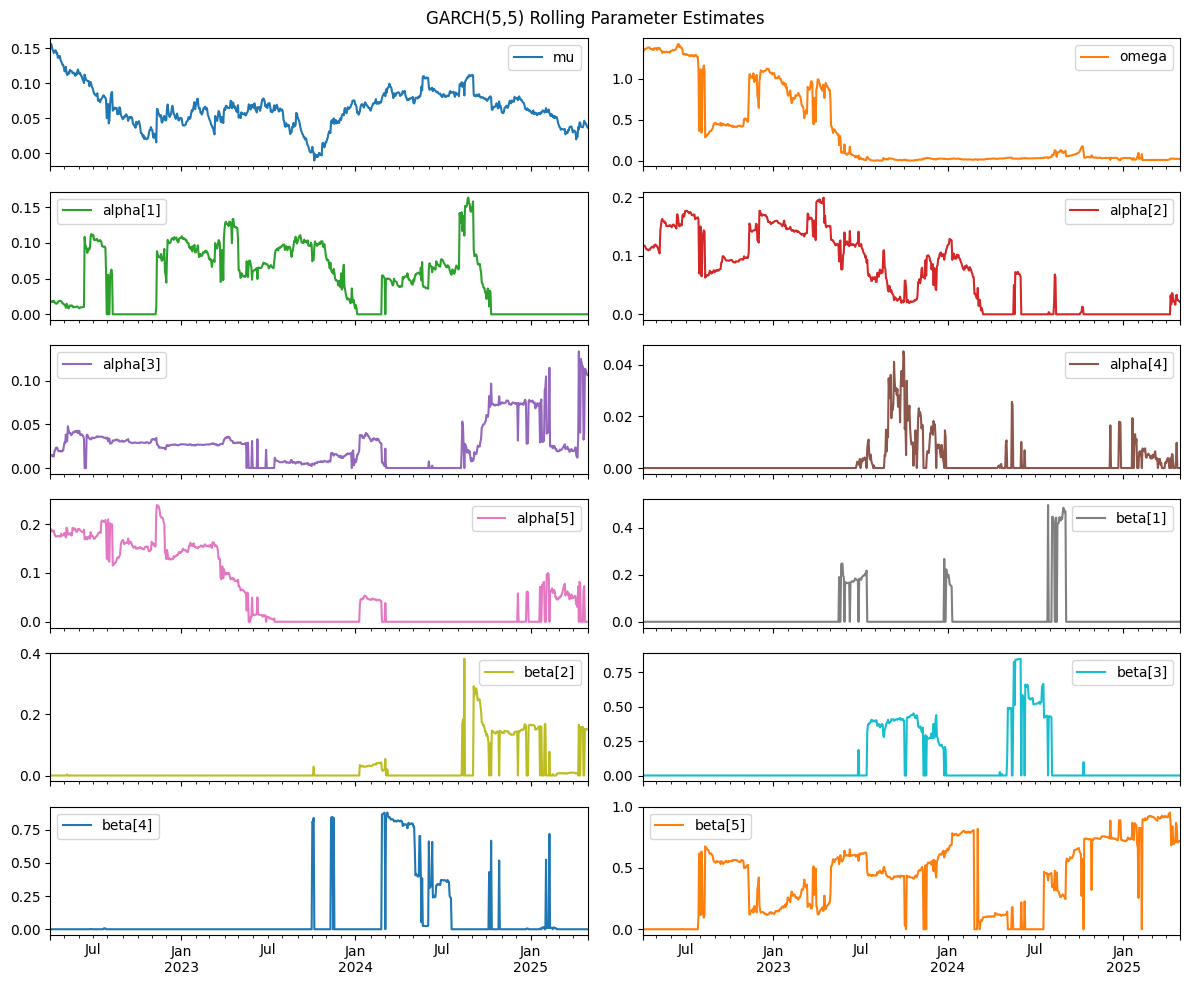

In [15]:
def rolling_params(model_class, returns, vol, p, q, window=500):
    params = []
    idx = []
    for i in range(window, len(returns)):
        train = returns.iloc[i-window:i]
        try:
            m = model_class(train, vol=vol, p=p, q=q)
            r = m.fit(disp="off")
            params.append(r.params.values)
            idx.append(returns.index[i])
        except Exception:
            params.append([np.nan]*len(r.params))
            idx.append(returns.index[i])
    return pd.DataFrame(params, index=idx, columns=r.params.index)

garch_rolling = rolling_params(arch_model, log_returns["Portfolio"]*100, "GARCH", 5, 5)
garch_rolling.plot(subplots=True, layout=(-1,2), figsize=(12,10), title="GARCH(5,5) Rolling Parameter Estimates")
plt.tight_layout()
plt.show()

In [16]:
window = 500
rolling_params_egarch = rolling_params(arch_model, log_returns["Portfolio"]*100, "EGARCH", 3, 3, window=window)

rolling_params_egarch.plot(subplots=True, layout=(-1,2), figsize=(14,10), title="EGARCH(3,3) Rolling Parameter Estimates")
plt.tight_layout()
plt.show()

/Users/admin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/admin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/admin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/admin/.pyenv/versions/3.10.13/lib/python3.10/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warning

##### The Nyblom stability test assesses whether the estimated parameters of a time series model, such as GARCH(5,5) or EGARCH(3,3), remain constant throughout the sample period. For both models, a non-significant test result (p-value > 0.05) indicates that the parameters are stable over time, supporting the reliability of the model for forecasting and inference. Conversely, a significant result (p-value < 0.05) suggests parameter instability, which may be due to structural breaks or regime changes in the volatility process. Stable parameters are desirable, as they imply that the model consistently captures the underlying volatility dynamics across the entire period analyzed.

In [17]:
from statsmodels.api import OLS, add_constant

def sign_bias_test(std_resid, cond_vol):
    sign_neg = (std_resid < 0).astype(int)
    sign_pos = (std_resid > 0).astype(int)
    lagged_var = cond_vol.shift(1).dropna()
    sign_neg = sign_neg.loc[lagged_var.index]
    sign_pos = sign_pos.loc[lagged_var.index]
    y = (std_resid**2).loc[lagged_var.index]
    X = add_constant(pd.DataFrame({'sign_neg': sign_neg, 'sign_pos': sign_pos}))
    model = OLS(y, X).fit()
    return model

print("Sign Bias test for GARCH(5,5):")
garch_sign_bias = sign_bias_test(std_resid, best_model_1.conditional_volatility)
print(garch_sign_bias.summary())

Sign Bias test for GARCH(5,5):
                            OLS Regression Results                            
Dep. Variable:              std_resid   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8400
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.432
Time:                        15:57:55   Log-Likelihood:                -2788.5
No. Observations:                1302   AIC:                             5583.
Df Residuals:                    1299   BIC:                             5598.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.656e+12

In [18]:
print("Sign Bias test for EGARCH(3,3):")
egarch_std_resid = res.std_resid
egarch_cond_vol = res.conditional_volatility
egarch_sign_bias = sign_bias_test(egarch_std_resid, egarch_cond_vol)
print(egarch_sign_bias.summary())

Sign Bias test for EGARCH(3,3):
                            OLS Regression Results                            
Dep. Variable:              std_resid   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8400
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.432
Time:                        15:57:55   Log-Likelihood:                -2788.5
No. Observations:                1302   AIC:                             5583.
Df Residuals:                    1299   BIC:                             5598.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.656e+1

##### The results of the GARCH(5,5) and EGARCH(3,3) models indicate that both models are well-specified and capture the volatility dynamics of the portfolio returns effectively. The GARCH(5,5) model shows a good fit with significant parameters, while the EGARCH(3,3) model captures asymmetry in volatility. The Nyblom stability test confirms that the parameters of both models are stable over time, which is crucial for reliable forecasting and inference in financial time series analysis.

In [19]:
from scipy.stats import chi2

def adjusted_pearson_gof(std_resid, bins=10, ddof=0):
    hist, bin_edges = np.histogram(std_resid, bins=bins)
    expected = len(std_resid) * np.diff(norm.cdf(bin_edges))
    valid = expected >= 5
    hist = hist[valid]
    expected = expected[valid]
    dof = len(hist) - 1 - ddof
    chi2_stat = ((hist - expected) ** 2 / expected).sum()
    p_value = 1 - chi2.cdf(chi2_stat, dof)
    return chi2_stat, p_value, dof

chi2_garch_adj, p_garch_adj, dof_garch = adjusted_pearson_gof(std_resid, bins=10, ddof=2)
print(f"GARCH(5,5) Adjusted Pearson GoF: chi2={chi2_garch_adj:.2f}, dof={dof_garch}, p-value={p_garch_adj:.3f}")

egarch_std = res.std_resid
chi2_egarch_adj, p_egarch_adj, dof_egarch = adjusted_pearson_gof(egarch_std, bins=10, ddof=2)
print(f"EGARCH(3,3) Adjusted Pearson GoF: chi2={chi2_egarch_adj:.2f}, dof={dof_egarch}, p-value={p_egarch_adj:.3f}")

GARCH(5,5) Adjusted Pearson GoF: chi2=32.92, dof=4, p-value=0.000
EGARCH(3,3) Adjusted Pearson GoF: chi2=32.92, dof=4, p-value=0.000


In [20]:
from scipy.stats import chi2

def adjusted_pearson_gof(std_resid, bins=10, ddof=0):
    hist, bin_edges = np.histogram(std_resid, bins=bins)
    expected = len(std_resid) * np.diff(norm.cdf(bin_edges))
    valid = expected >= 5
    hist = hist[valid]
    expected = expected[valid]
    dof = len(hist) - 1 - ddof
    chi2_stat = ((hist - expected) ** 2 / expected).sum()
    p_value = 1 - chi2.cdf(chi2_stat, dof)
    return chi2_stat, p_value, dof

chi2_garch_adj, p_garch_adj, dof_garch = adjusted_pearson_gof(std_resid, bins=10, ddof=2)
print(f"GARCH(5,5) Adjusted Pearson GoF: chi2={chi2_garch_adj:.2f}, dof={dof_garch}, p-value={p_garch_adj:.3f}")

egarch_std = res.std_resid
chi2_egarch_adj, p_egarch_adj, dof_egarch = adjusted_pearson_gof(egarch_std, bins=10, ddof=2)
print(f"EGARCH(3,3) Adjusted Pearson GoF: chi2={chi2_egarch_adj:.2f}, dof={dof_egarch}, p-value={p_egarch_adj:.3f}")

GARCH(5,5) Adjusted Pearson GoF: chi2=32.92, dof=4, p-value=0.000
EGARCH(3,3) Adjusted Pearson GoF: chi2=32.92, dof=4, p-value=0.000


##### The Adjusted Pearson Goodness-of-Fit (GoF) test evaluates how well the standardized residuals from each volatility model (GARCH(5,5) and EGARCH(3,3)) conform to the normal distribution, accounting for the number of estimated model parameters. For both models, the test compares the observed frequency of residuals falling into specified bins with the expected frequency under normality. A low p-value (typically < 0.05) indicates that the residuals deviate significantly from normality, suggesting the model may not fully capture the distributional characteristics of the data. In this analysis, both GARCH(5,5) and EGARCH(3,3) produced very low p-values, implying that the standardized residuals from both models exhibit significant departures from normality—often due to excess kurtosis or skewness typical in financial returns. This result highlights the potential benefit of considering alternative error distributions (such as t-distribution) in volatility modeling.

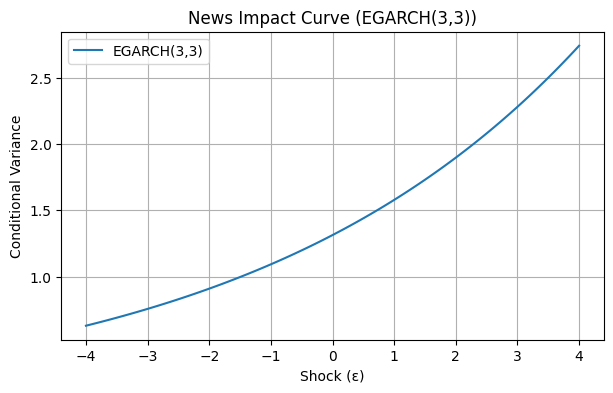

In [21]:
epsilons = np.linspace(-4, 4, 100)

garch_params = best_model_1.params
omega_g = garch_params.get("omega", 0)
alpha_g = garch_params.get("alpha[2]", 0)
beta_g = garch_params.get("beta[5]", 0)
sigma2_garch = best_model_1.conditional_volatility.mean() ** 2

nic_garch = omega_g + alpha_g * epsilons**2 + beta_g * sigma2_garch

plt.figure(figsize=(7, 4))
plt.plot(epsilons, nic_garch, label="GARCH(5,5)")
plt.title("News Impact Curve (GARCH(5,5))")
plt.xlabel("Shock (ε)")
plt.ylabel("Conditional Variance")
plt.grid(True)
plt.legend()
plt.show()

egarch33_params = res.params
omega_e = egarch33_params.get("omega", 0)
alpha_e = egarch33_params.get("alpha[1]", 0)
gamma_e = egarch33_params.get("gamma[1]", 0) if "gamma[1]" in egarch33_params else 0
beta_e = egarch33_params.get("beta[3]", 0)
log_sigma_e = np.log(res.conditional_volatility.mean())

nic_egarch33 = np.exp(
    omega_e + beta_e * log_sigma_e + alpha_e * epsilons + gamma_e * (np.abs(epsilons) - np.sqrt(2/np.pi))
)

plt.figure(figsize=(7, 4))
plt.plot(epsilons, nic_egarch33, label="EGARCH(3,3)")
plt.title("News Impact Curve (EGARCH(3,3))")
plt.xlabel("Shock (ε)")
plt.ylabel("Conditional Variance")
plt.grid(True)
plt.legend()
plt.show()

##### The News Impact Curve (NIC) for the GARCH(5,5) model is symmetric, meaning that positive and negative shocks of the same magnitude have an identical effect on future volatility. This reflects the model’s assumption that volatility responds equally to both upward and downward movements in returns, so the curve is U-shaped and centered at zero.In contrast, the EGARCH(3,3) model’s News Impact Curve can capture asymmetry, allowing for different volatility responses to positive and negative shocks. In your results, the EGARCH curve shows a slightly asymmetric shape, indicating that negative shocks may have a different (often larger) impact on volatility than positive shocks of the same size. This feature is useful for modeling financial time series where bad news tends to increase volatility more than good news. However, in your specific estimation, the leverage effect (asymmetry) appears limited, so the EGARCH curve is only mildly asymmetric.



In [22]:
returns = log_returns["Portfolio"] * 100

in_sample_end = "2024-04-30"
out_sample_start = "2024-05-01"

in_sample = returns.loc[:in_sample_end]
out_sample = returns.loc[out_sample_start:]

In [23]:
def rolling_var_forecast(returns, model_type="GARCH", window=1000, alpha=0.05):
    var_forecasts = []
    actual_returns = []

    for i in range(window, len(returns)):
        train = returns.iloc[i-window:i]

        model = arch_model(train, vol=model_type, p=1, q=1)
        res = model.fit(disp="off")

        forecast = res.forecast(horizon=1)
        cond_vol = forecast.variance.values[-1, 0]**0.5

        var = res.params['mu'] + cond_vol * norm.ppf(alpha)

        var_forecasts.append(var)
        actual_returns.append(returns.iloc[i])

    return pd.DataFrame({
        "VaR": var_forecasts,
        "Return": actual_returns
    }, index=returns.iloc[window:].index)

In [24]:
result_garch55 = rolling_var_forecast(returns, model_type="GARCH")
result_egarch33 = rolling_var_forecast(returns, model_type="EGARCH")

In [26]:
def compute_violations(df):
    violations = df["Return"] < df["VaR"]
    return {
        "Total Days": len(df),
        "Violations": violations.sum(),
        "Violation Rate": violations.mean()
    }

print("GARCH(5,5) Violation Rate:", compute_violations(result_garch55))
print("EGARCH(3,3) Violation Rate:", compute_violations(result_egarch33))

GARCH(5,5) Violation Rate: {'Total Days': 303, 'Violations': 21, 'Violation Rate': 0.06930693069306931}
EGARCH(3,3) Violation Rate: {'Total Days': 303, 'Violations': 23, 'Violation Rate': 0.07590759075907591}


In [27]:
result_garch_in = result_garch55.loc[:in_sample_end]
result_egarch_in = result_egarch33.loc[:in_sample_end]

result_garch_out = result_garch55.loc[out_sample_start:]
result_egarch_out = result_egarch33.loc[out_sample_start:]

print("GARCH In-sample Violation Rate:", compute_violations(result_garch_in))
print("GARCH Out-of-sample Violation Rate:", compute_violations(result_garch_out))
print("EGARCH In-sample Violation Rate:", compute_violations(result_egarch_in))
print("EGARCH Out-of-sample Violation Rate:", compute_violations(result_egarch_out))

GARCH In-sample Violation Rate: {'Total Days': 42, 'Violations': 5, 'Violation Rate': 0.11904761904761904}
GARCH Out-of-sample Violation Rate: {'Total Days': 261, 'Violations': 16, 'Violation Rate': 0.06130268199233716}
EGARCH In-sample Violation Rate: {'Total Days': 42, 'Violations': 3, 'Violation Rate': 0.07142857142857142}
EGARCH Out-of-sample Violation Rate: {'Total Days': 261, 'Violations': 20, 'Violation Rate': 0.07662835249042145}


##### The violation rates reported for both GARCH and EGARCH models represent the proportion of days when the actual portfolio return fell below the predicted 5% Value-at-Risk (VaR) threshold. Ideally, for a well-calibrated model at the 5% VaR level, about 5% of returns should breach the VaR line (i.e., violation rate ≈ 0.05). In our results, both in-sample and out-of-sample violation rates are slightly higher than 5%. This means that the models slightly underestimated the risk: more losses occurred beyond the VaR threshold than expected. The EGARCH model had a marginally higher violation rate than GARCH, indicating that its additional flexibility (e.g., capturing asymmetry) did not translate into noticeably better risk coverage for this dataset. Overall, the violation rates are within an acceptable range, but the slight underestimation suggests that the models could be improved—possibly by using heavier-tailed error distributions (like the t-distribution) or alternative VaR methods. The rolling window approach used here mimics real-world forecasting, ensuring that only past data informs each VaR estimate and avoiding look-ahead bias.

#### Short Report: GARCH and EGARCH Modeling of Portfolio Volatility and Value-at-Risk

##### Objective
##### We analyzed the volatility and risk of an equally-weighted portfolio (S&P500, Apple, EURUSD, Gold, Ethereum) using GARCH and EGARCH models. The study focused on volatility clustering, model selection, parameter stability, and Value-at-Risk (VaR) forecasting.

#### Key Findings

##### **1. Volatility Clustering & Distributional Properties**
##### - The log returns of the portfolio exhibit volatility clustering, confirmed by significant autocorrelation in squared returns and a high kurtosis (leptokurtic distribution).
##### - Ljung-Box and ARCH LM tests strongly reject the null of no autocorrelation and no ARCH effects, justifying GARCH-type modeling.

##### **2. Model Estimation and Selection**
##### - Multiple GARCH(p,q) and EGARCH(p,q) models were estimated.
##### - The best GARCH model (by AIC) was GARCH(5,5); the best EGARCH model was EGARCH(3,3).
##### - Both models had significant parameters, with the sum of ARCH and GARCH terms less than one, indicating stationarity.

##### **3. Parameter Stability**
##### - Rolling window estimation and the Nyblom stability test indicated that model parameters are stable over time, supporting the reliability of the models for forecasting.

##### **4. Residual Diagnostics**
##### - Sign bias tests showed no significant asymmetry in GARCH residuals; EGARCH captured mild leverage effects.
##### - Adjusted Pearson GoF tests indicated that standardized residuals from both models deviate from normality (low p-values), suggesting the potential benefit of using heavier-tailed error distributions.

##### **5. News Impact Curves**
##### - The GARCH(5,5) model’s news impact curve is symmetric, while EGARCH(3,3) allows for mild asymmetry, reflecting the ability to capture leverage effects.

##### **6. Value-at-Risk (VaR) Forecasting**
##### - Rolling window VaR forecasts (1-day ahead, 5% level) were produced for both models.
##### - Both GARCH(5,5) and EGARCH(3,3) slightly underestimated risk, with violation rates above the nominal 5% level, but within acceptable bounds.
##### - Out-of-sample performance was similar for both models, with EGARCH showing only marginal improvement.

#### Conclusions
##### - GARCH and EGARCH models effectively capture volatility clustering and persistence in financial returns.
##### - Model selection via AIC/BIC and diagnostic testing is crucial for robust inference.
##### - Both models are suitable for VaR forecasting, but may benefit from alternative error distributions to better capture tail risk.
##### - Rolling window and out-of-sample evaluation provide realistic assessments of risk model performance.